In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)     

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

C:\Users\User\AppData\Local\Temp\ipykernel_817520\448054465.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.39307412 0.69695044 0.32924264 ... 0.33095551 0.77165354 0.45747266]
 [0.45747266 0.51683609 0.42215989 ... 0.33095551 0.77165354 0.5246051 ]
 [0.38487242 0.62674714 0.3411641  ... 0.33095551 0.77165354 0.4954435 ]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.33095551 0.77165354 0.4936209 ]
 [0.44896719 0.51620076 0.3997195  ... 0.33095551 0.77165354 0.54009721]
 [0.46780073 0.52414231 0.42356241 ... 0.33095551 0.77165354 0.49696233]]
Fold 2:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.38166311 0.62313675 0.34639831 ... 0.33095551 0.77165354 0.47852574]
 [0.39415169 0.71548931 0.32450565 ... 0.33095551 0.77165354 0.45872677]
 [0.45872677 0.53175632 0.4180791  ... 0.33095551 0.77165354 0.52604325]
 ...
 [0.54249162 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-20 03:43:21,518] A new study created in memory with name: no-name-f9087b6b-e606-4de8-a673-f6e7e913a81b
[I 2025-05-20 03:48:06,002] Trial 0 finished with value: 0.5004262149333953 and parameters: {'lr': 0.14994900290714736, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3643222240073706}. Best is trial 0 with value: 0.5004262149333953.


Cross Validation Accuracies:
[0.560366153717041, 0.30600425601005554, 0.5175073742866516, 0.5705047845840454, 0.5477485060691833]
Mean Cross Validation Accuracy:
0.5004262149333953
Standard Deviation of Cross Validation Accuracy:
0.09882799759222954


[I 2025-05-20 03:55:57,016] Trial 1 finished with value: 0.031656714901328084 and parameters: {'lr': 0.03596340665568717, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4778057422704821}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.026140321046113968, 0.026782281696796417, 0.03302714228630066, 0.04252879321575165, 0.029805036261677742]
Mean Cross Validation Accuracy:
0.031656714901328084
Standard Deviation of Cross Validation Accuracy:
0.005961536246778411


[I 2025-05-20 04:04:36,016] Trial 2 finished with value: 0.32043799161911013 and parameters: {'lr': 0.037451274014794256, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35382192424355685}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.30233410000801086, 0.16576312482357025, 0.44776451587677, 0.17588309943675995, 0.5104451179504395]
Mean Cross Validation Accuracy:
0.32043799161911013
Standard Deviation of Cross Validation Accuracy:
0.13961585440039503


[I 2025-05-20 04:11:38,147] Trial 3 finished with value: 0.06953307315707206 and parameters: {'lr': 0.0026910739304655384, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2314242615177609}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.04771672561764717, 0.06498289108276367, 0.09529878944158554, 0.041697874665260315, 0.09796908497810364]
Mean Cross Validation Accuracy:
0.06953307315707206
Standard Deviation of Cross Validation Accuracy:
0.02342620052799334


[I 2025-05-20 04:18:13,246] Trial 4 finished with value: 70.15549774169922 and parameters: {'lr': 0.6960995511816384, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2568554148994219}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[70.19383239746094, 70.92977905273438, 83.06768798828125, 62.61384201049805, 63.972347259521484]
Mean Cross Validation Accuracy:
70.15549774169922
Standard Deviation of Cross Validation Accuracy:
7.244771343687709


[I 2025-05-20 04:24:49,043] Trial 5 finished with value: 0.04670885726809502 and parameters: {'lr': 0.07928314358882811, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4602903732896484}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.03200056776404381, 0.0637826919555664, 0.032815758138895035, 0.0610058456659317, 0.04393942281603813]
Mean Cross Validation Accuracy:
0.04670885726809502
Standard Deviation of Cross Validation Accuracy:
0.01351252351647151


[I 2025-05-20 04:31:30,040] Trial 6 finished with value: 0.0653222732245922 and parameters: {'lr': 0.09628531325043468, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1665262552992024}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.053370069712400436, 0.08598140627145767, 0.06474210321903229, 0.061399150639772415, 0.06111863628029823]
Mean Cross Validation Accuracy:
0.0653222732245922
Standard Deviation of Cross Validation Accuracy:
0.010982285724340318


[I 2025-05-20 04:40:35,477] Trial 7 finished with value: 44.11514663696289 and parameters: {'lr': 0.3996993358115665, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3017073081511208}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[41.059844970703125, 44.73701477050781, 49.16835021972656, 36.3441047668457, 49.26641845703125]
Mean Cross Validation Accuracy:
44.11514663696289
Standard Deviation of Cross Validation Accuracy:
4.943301483979483


[I 2025-05-20 04:47:32,842] Trial 8 finished with value: 0.1619525283575058 and parameters: {'lr': 0.00834560327147059, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23463798692010338}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.15711088478565216, 0.13597266376018524, 0.1799829751253128, 0.16517235338687897, 0.17152376472949982]
Mean Cross Validation Accuracy:
0.1619525283575058
Standard Deviation of Cross Validation Accuracy:
0.015003117852813547


[I 2025-05-20 04:53:46,941] Trial 9 finished with value: 0.2729428209364414 and parameters: {'lr': 0.017930844709293757, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4311234831467161}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.035052139312028885, 0.47825679183006287, 0.06564146280288696, 0.44478651881217957, 0.34097719192504883]
Mean Cross Validation Accuracy:
0.2729428209364414
Standard Deviation of Cross Validation Accuracy:
0.18755190655777088


[I 2025-05-20 05:01:07,127] Trial 10 finished with value: 0.08820848762989045 and parameters: {'lr': 0.0014917366075650291, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4946724367592945}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.04786377027630806, 0.05755006894469261, 0.2060757279396057, 0.06545358896255493, 0.0640992820262909]
Mean Cross Validation Accuracy:
0.08820848762989045
Standard Deviation of Cross Validation Accuracy:
0.059261050279324025


[I 2025-05-20 05:06:33,398] Trial 11 finished with value: 0.03570948727428913 and parameters: {'lr': 0.06111656201062265, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49190922204476223}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.03927427902817726, 0.029215741902589798, 0.030208909884095192, 0.040925558656454086, 0.03892294690012932]
Mean Cross Validation Accuracy:
0.03570948727428913
Standard Deviation of Cross Validation Accuracy:
0.004953111027572737


[I 2025-05-20 05:12:19,946] Trial 12 finished with value: 0.05323277488350868 and parameters: {'lr': 0.013543572907869313, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.41198477115249343}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.07190222293138504, 0.06973186880350113, 0.03784419596195221, 0.058775123208761215, 0.027910463511943817]
Mean Cross Validation Accuracy:
0.05323277488350868
Standard Deviation of Cross Validation Accuracy:
0.017490076214670826


[I 2025-05-20 05:17:31,910] Trial 13 finished with value: 0.03273394219577312 and parameters: {'lr': 0.0485620464215342, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49984715516722034}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.03099840320646763, 0.03272342309355736, 0.02983570657670498, 0.042293980717659, 0.02781819738447666]
Mean Cross Validation Accuracy:
0.03273394219577312
Standard Deviation of Cross Validation Accuracy:
0.005039263031997361


[I 2025-05-20 05:23:46,729] Trial 14 finished with value: 0.04409986846148968 and parameters: {'lr': 0.007316907797417124, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.38659527610293554}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.07783852517604828, 0.032700128853321075, 0.033757369965314865, 0.04936385154724121, 0.026839466765522957]
Mean Cross Validation Accuracy:
0.04409986846148968
Standard Deviation of Cross Validation Accuracy:
0.0184436942059527


[I 2025-05-20 05:29:36,897] Trial 15 finished with value: 0.03254505097866058 and parameters: {'lr': 0.02774774393800404, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44642609163635455}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.02611544169485569, 0.030417172238230705, 0.03825339302420616, 0.041123274713754654, 0.026815973222255707]
Mean Cross Validation Accuracy:
0.03254505097866058
Standard Deviation of Cross Validation Accuracy:
0.006080479697747068


[I 2025-05-20 05:37:39,917] Trial 16 finished with value: 1.8587051391601563 and parameters: {'lr': 0.27535556957351737, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11223540288551567}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[2.01847767829895, 0.9452908039093018, 1.8744702339172363, 2.055678606033325, 2.3996083736419678]
Mean Cross Validation Accuracy:
1.8587051391601563
Standard Deviation of Cross Validation Accuracy:
0.4881549766298073


[I 2025-05-20 05:42:54,192] Trial 17 finished with value: 0.034837518632411954 and parameters: {'lr': 0.021827900663785718, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3211172790605542}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.02656109444797039, 0.023218171671032906, 0.03523288667201996, 0.04125744476914406, 0.04791799560189247]
Mean Cross Validation Accuracy:
0.034837518632411954
Standard Deviation of Cross Validation Accuracy:
0.009121173897329964


[I 2025-05-20 05:50:46,497] Trial 18 finished with value: 0.04325492605566979 and parameters: {'lr': 0.0044276978503539725, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4372923234621807}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.030705809593200684, 0.05439561977982521, 0.03567342460155487, 0.0650065466761589, 0.030493229627609253]
Mean Cross Validation Accuracy:
0.04325492605566979
Standard Deviation of Cross Validation Accuracy:
0.013964730146210889


[I 2025-05-20 05:57:21,068] Trial 19 finished with value: 0.39277618527412417 and parameters: {'lr': 0.02993617441527193, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.40316033142860785}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.7012102603912354, 0.5068427324295044, 0.31308695673942566, 0.2341301441192627, 0.20861083269119263]
Mean Cross Validation Accuracy:
0.39277618527412417
Standard Deviation of Cross Validation Accuracy:
0.186321535246927


[I 2025-05-20 06:05:29,352] Trial 20 finished with value: 0.03732915595173836 and parameters: {'lr': 0.1655948616888518, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.45551353796041577}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.04850262030959129, 0.025455312803387642, 0.04407691955566406, 0.041574228554964066, 0.027036698535084724]
Mean Cross Validation Accuracy:
0.03732915595173836
Standard Deviation of Cross Validation Accuracy:
0.009330831598551068


[I 2025-05-20 06:10:15,201] Trial 21 finished with value: 0.06463386639952659 and parameters: {'lr': 0.03540850882413364, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49544737323384497}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.06850962340831757, 0.0463830940425396, 0.07626679539680481, 0.06502675265073776, 0.06698306649923325]
Mean Cross Validation Accuracy:
0.06463386639952659
Standard Deviation of Cross Validation Accuracy:
0.00989050374640566


[I 2025-05-20 06:15:39,943] Trial 22 finished with value: 0.04188982322812081 and parameters: {'lr': 0.05601852114431917, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46441745960876696}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.040237996727228165, 0.021231509745121002, 0.0674673393368721, 0.0479724295437336, 0.032539840787649155]
Mean Cross Validation Accuracy:
0.04188982322812081
Standard Deviation of Cross Validation Accuracy:
0.015544285434025171


[I 2025-05-20 06:20:42,143] Trial 23 finished with value: 0.03315993882715702 and parameters: {'lr': 0.011836855589157463, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.463165816128676}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.025441832840442657, 0.02622317709028721, 0.03487090393900871, 0.051094647496938705, 0.02816913276910782]
Mean Cross Validation Accuracy:
0.03315993882715702
Standard Deviation of Cross Validation Accuracy:
0.009562187461132875


[I 2025-05-20 06:25:17,834] Trial 24 finished with value: 0.03180724047124386 and parameters: {'lr': 0.15065411291832767, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3695490600392505}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.027535907924175262, 0.028624027967453003, 0.03457161784172058, 0.041396405547857285, 0.02690824307501316]
Mean Cross Validation Accuracy:
0.03180724047124386
Standard Deviation of Cross Validation Accuracy:
0.00551309655589596


[I 2025-05-20 06:30:25,402] Trial 25 finished with value: 0.03254371955990791 and parameters: {'lr': 0.13786391175634444, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3608327800590618}. Best is trial 1 with value: 0.031656714901328084.


Cross Validation Accuracies:
[0.02946491725742817, 0.025945009663701057, 0.0369703471660614, 0.043193183839321136, 0.0271451398730278]
Mean Cross Validation Accuracy:
0.03254371955990791
Standard Deviation of Cross Validation Accuracy:
0.0065600728646823085


[I 2025-05-20 06:35:11,294] Trial 26 finished with value: 0.031151793152093887 and parameters: {'lr': 0.14383572342495482, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3413805269973507}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.03108210116624832, 0.025801150128245354, 0.0306346844881773, 0.040766604244709015, 0.027474425733089447]
Mean Cross Validation Accuracy:
0.031151793152093887
Standard Deviation of Cross Validation Accuracy:
0.0051936357706885445


[I 2025-05-20 06:39:44,484] Trial 27 finished with value: 0.0585251621901989 and parameters: {'lr': 0.33934214754824277, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.334402563176278}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.046880196779966354, 0.07638488709926605, 0.03853781148791313, 0.07600396126508713, 0.054818954318761826]
Mean Cross Validation Accuracy:
0.0585251621901989
Standard Deviation of Cross Validation Accuracy:
0.015318704744304234


[I 2025-05-20 06:44:27,413] Trial 28 finished with value: 14.312230968475342 and parameters: {'lr': 0.5553513290128158, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.278091645531731}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[5.047491073608398, 32.47869873046875, 1.6685242652893066, 2.853512763977051, 29.512928009033203]
Mean Cross Validation Accuracy:
14.312230968475342
Standard Deviation of Cross Validation Accuracy:
13.697318634478805


[I 2025-05-20 06:50:45,452] Trial 29 finished with value: 0.7338785767555237 and parameters: {'lr': 0.20054971825525408, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3819711031185804}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[1.1653555631637573, 0.8883695006370544, 0.6454289555549622, 0.6223905086517334, 0.3478483557701111]
Mean Cross Validation Accuracy:
0.7338785767555237
Standard Deviation of Cross Validation Accuracy:
0.27543133144062776


[I 2025-05-20 06:55:11,768] Trial 30 finished with value: 0.7399730801582336 and parameters: {'lr': 0.12149215969405854, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3374164934483916}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.5032365322113037, 1.0889865159988403, 1.0005080699920654, 0.7673472762107849, 0.33978700637817383]
Mean Cross Validation Accuracy:
0.7399730801582336
Standard Deviation of Cross Validation Accuracy:
0.28517759123599884


[I 2025-05-20 06:59:33,981] Trial 31 finished with value: 0.04220890253782272 and parameters: {'lr': 0.21214928910951425, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37027981658599346}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.047480836510658264, 0.0462302602827549, 0.036372438073158264, 0.0408988781273365, 0.04006209969520569]
Mean Cross Validation Accuracy:
0.04220890253782272
Standard Deviation of Cross Validation Accuracy:
0.0041074042843404854


[I 2025-05-20 07:03:45,983] Trial 32 finished with value: 0.03472625054419041 and parameters: {'lr': 0.12710275349047293, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.36123912309107775}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.03338359296321869, 0.034170813858509064, 0.032713983207941055, 0.04426603764295578, 0.029096825048327446]
Mean Cross Validation Accuracy:
0.03472625054419041
Standard Deviation of Cross Validation Accuracy:
0.005076582086942351


[I 2025-05-20 07:08:07,290] Trial 33 finished with value: 0.03452892079949379 and parameters: {'lr': 0.08278752731764014, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2992591481035636}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.027231721207499504, 0.031526073813438416, 0.04516201838850975, 0.04190979525446892, 0.02681499533355236]
Mean Cross Validation Accuracy:
0.03452892079949379
Standard Deviation of Cross Validation Accuracy:
0.007606719793167151


[I 2025-05-20 07:12:17,874] Trial 34 finished with value: 0.07938774153590203 and parameters: {'lr': 0.4653498124105624, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40646906941413663}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.026480965316295624, 0.19370879232883453, 0.10575027018785477, 0.04302099719643593, 0.027977682650089264]
Mean Cross Validation Accuracy:
0.07938774153590203
Standard Deviation of Cross Validation Accuracy:
0.064076433717509


[I 2025-05-20 07:16:04,948] Trial 35 finished with value: 0.03503320254385471 and parameters: {'lr': 0.2678503002624584, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2035197759535468}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.049514785408973694, 0.023776443675160408, 0.02997022680938244, 0.0420701690018177, 0.029834387823939323]
Mean Cross Validation Accuracy:
0.03503320254385471
Standard Deviation of Cross Validation Accuracy:
0.009366014704425739


[I 2025-05-20 07:21:24,848] Trial 36 finished with value: 0.031165554746985437 and parameters: {'lr': 0.11755997624302582, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3517568165346081}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[0.030733643099665642, 0.026754695922136307, 0.029777897521853447, 0.04175085946917534, 0.026810677722096443]
Mean Cross Validation Accuracy:
0.031165554746985437
Standard Deviation of Cross Validation Accuracy:
0.005524155062664748


[I 2025-05-20 07:27:25,119] Trial 37 finished with value: 12.918366050720214 and parameters: {'lr': 0.9466858780875163, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.27347521688723253}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[18.0865535736084, 21.22418785095215, 18.598037719726562, 2.8009192943573, 3.882131814956665]
Mean Cross Validation Accuracy:
12.918366050720214
Standard Deviation of Cross Validation Accuracy:
7.899009638531685


[I 2025-05-20 07:33:08,260] Trial 38 finished with value: 9.459043502807617 and parameters: {'lr': 0.08968351648691833, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30186762060147243}. Best is trial 26 with value: 0.031151793152093887.


Cross Validation Accuracies:
[9.869680404663086, 8.557792663574219, 10.099494934082031, 8.595784187316895, 10.172465324401855]
Mean Cross Validation Accuracy:
9.459043502807617
Standard Deviation of Cross Validation Accuracy:
0.7273570124105714


[I 2025-05-20 07:39:32,401] Trial 39 finished with value: 0.03060242161154747 and parameters: {'lr': 0.0450897777625051, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3375082940628623}. Best is trial 39 with value: 0.03060242161154747.


Cross Validation Accuracies:
[0.027664829045534134, 0.024601297453045845, 0.03292514756321907, 0.04094595089554787, 0.026874883100390434]
Mean Cross Validation Accuracy:
0.03060242161154747
Standard Deviation of Cross Validation Accuracy:
0.005846727948132185


[I 2025-05-20 07:47:40,859] Trial 40 finished with value: 0.046808059141039846 and parameters: {'lr': 0.04937900881679555, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23379096203522093}. Best is trial 39 with value: 0.03060242161154747.


Cross Validation Accuracies:
[0.030801570042967796, 0.060846034437417984, 0.06252726912498474, 0.041000522673130035, 0.038864899426698685]
Mean Cross Validation Accuracy:
0.046808059141039846
Standard Deviation of Cross Validation Accuracy:
0.012626854495569433


[I 2025-05-20 07:53:20,266] Trial 41 finished with value: 0.030761653557419777 and parameters: {'lr': 0.08289245854532168, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3333195754159752}. Best is trial 39 with value: 0.03060242161154747.


Cross Validation Accuracies:
[0.026488475501537323, 0.02523583173751831, 0.03036113828420639, 0.04485204070806503, 0.026870781555771828]
Mean Cross Validation Accuracy:
0.030761653557419777
Standard Deviation of Cross Validation Accuracy:
0.007247524611271473


[I 2025-05-20 07:59:07,605] Trial 42 finished with value: 0.030439331009984017 and parameters: {'lr': 0.0643179826644555, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33975221414939427}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[0.026026876643300056, 0.02181970328092575, 0.03494375944137573, 0.042608506977558136, 0.026797808706760406]
Mean Cross Validation Accuracy:
0.030439331009984017
Standard Deviation of Cross Validation Accuracy:
0.007421686326352078


[I 2025-05-20 08:03:44,746] Trial 43 finished with value: 0.03176605030894279 and parameters: {'lr': 0.06930300754183738, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.339074469097188}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[0.029094554483890533, 0.023855553939938545, 0.035767897963523865, 0.042589470744132996, 0.027522774413228035]
Mean Cross Validation Accuracy:
0.03176605030894279
Standard Deviation of Cross Validation Accuracy:
0.006646494529326325


[I 2025-05-20 08:10:02,333] Trial 44 finished with value: 0.5172203533351422 and parameters: {'lr': 0.09299911654471521, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31574821763489147}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[0.025796927511692047, 2.4441680908203125, 0.040869828313589096, 0.04591168463230133, 0.029355235397815704]
Mean Cross Validation Accuracy:
0.5172203533351422
Standard Deviation of Cross Validation Accuracy:
0.9635018031773502


[I 2025-05-20 08:14:21,474] Trial 45 finished with value: 0.03310060985386372 and parameters: {'lr': 0.04129371795703837, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34847400325582534}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[0.025959402322769165, 0.0328044518828392, 0.03763848543167114, 0.04225020110607147, 0.026850508525967598]
Mean Cross Validation Accuracy:
0.03310060985386372
Standard Deviation of Cross Validation Accuracy:
0.006236275426840439


[I 2025-05-20 08:19:16,510] Trial 46 finished with value: 1.0069582860916853 and parameters: {'lr': 0.10870823683686826, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2797200629854366}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[4.899631977081299, 0.02308579720556736, 0.04130442440509796, 0.043968964368104935, 0.02680026739835739]
Mean Cross Validation Accuracy:
1.0069582860916853
Standard Deviation of Cross Validation Accuracy:
1.946353467120623


[I 2025-05-20 08:23:48,817] Trial 47 finished with value: 0.6384322345256805 and parameters: {'lr': 0.06369130858752181, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.31606997386839614}. Best is trial 42 with value: 0.030439331009984017.


Cross Validation Accuracies:
[1.7510842084884644, 0.22709470987319946, 0.14868976175785065, 0.2407044917345047, 0.8245880007743835]
Mean Cross Validation Accuracy:
0.6384322345256805
Standard Deviation of Cross Validation Accuracy:
0.6066105819513312


[I 2025-05-20 08:28:08,344] Trial 48 finished with value: 0.029577907547354697 and parameters: {'lr': 0.021689385492472412, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2546877834191972}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.025445135310292244, 0.023055849596858025, 0.0315895713865757, 0.04097643122076988, 0.02682255022227764]
Mean Cross Validation Accuracy:
0.029577907547354697
Standard Deviation of Cross Validation Accuracy:
0.00634321958625685


[I 2025-05-20 08:32:38,335] Trial 49 finished with value: 0.041121798753738406 and parameters: {'lr': 0.024946137432515583, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.20173577540316762}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.048925504088401794, 0.04658228158950806, 0.03702627122402191, 0.04069859907031059, 0.03237633779644966]
Mean Cross Validation Accuracy:
0.041121798753738406
Standard Deviation of Cross Validation Accuracy:
0.006068776166974189


[I 2025-05-20 08:40:24,125] Trial 50 finished with value: 1.0993433237075805 and parameters: {'lr': 0.015832752885640407, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2684927592862003}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[1.2456427812576294, 0.8573805093765259, 1.2937180995941162, 0.791571855545044, 1.3084033727645874]
Mean Cross Validation Accuracy:
1.0993433237075805
Standard Deviation of Cross Validation Accuracy:
0.22634507683005847


[I 2025-05-20 08:46:39,498] Trial 51 finished with value: 0.0362737700343132 and parameters: {'lr': 0.048966524989345526, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25513884614247984}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.0345686636865139, 0.024695366621017456, 0.04785282909870148, 0.041199080646038055, 0.03305291011929512]
Mean Cross Validation Accuracy:
0.0362737700343132
Standard Deviation of Cross Validation Accuracy:
0.007818875178554216


[I 2025-05-20 08:52:22,959] Trial 52 finished with value: 0.04252577498555184 and parameters: {'lr': 0.03714466211578731, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29676188414741295}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.03703710436820984, 0.043471869081258774, 0.04738868772983551, 0.0574139803647995, 0.027317233383655548]
Mean Cross Validation Accuracy:
0.04252577498555184
Standard Deviation of Cross Validation Accuracy:
0.010075980514206948


[I 2025-05-20 08:58:27,116] Trial 53 finished with value: 0.0433432936668396 and parameters: {'lr': 0.008077921058432672, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3300096745904659}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.04097582772374153, 0.06633452326059341, 0.03137171268463135, 0.04207998141646385, 0.03595442324876785]
Mean Cross Validation Accuracy:
0.0433432936668396
Standard Deviation of Cross Validation Accuracy:
0.012113724846924714


[I 2025-05-20 09:03:02,799] Trial 54 finished with value: 0.03492907844483852 and parameters: {'lr': 0.07148521307176618, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3892719736567861}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.03098718635737896, 0.03400731831789017, 0.03987814486026764, 0.04298087954521179, 0.02679186314344406]
Mean Cross Validation Accuracy:
0.03492907844483852
Standard Deviation of Cross Validation Accuracy:
0.005863909739522888


[I 2025-05-20 09:09:47,802] Trial 55 finished with value: 0.049517159909009935 and parameters: {'lr': 0.010939835851970633, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34996469404456154}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.044390302151441574, 0.05511109530925751, 0.036435119807720184, 0.07876574993133545, 0.03288353234529495]
Mean Cross Validation Accuracy:
0.049517159909009935
Standard Deviation of Cross Validation Accuracy:
0.016497721910389285


[I 2025-05-20 09:15:51,015] Trial 56 finished with value: 0.03921179436147213 and parameters: {'lr': 0.022977553969112226, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24864026276526968}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.02631109207868576, 0.05325877293944359, 0.04126164689660072, 0.04646226391196251, 0.028765195980668068]
Mean Cross Validation Accuracy:
0.03921179436147213
Standard Deviation of Cross Validation Accuracy:
0.01029221403204634


[I 2025-05-20 09:21:53,596] Trial 57 finished with value: 0.030838124081492425 and parameters: {'lr': 0.018770528700000764, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2898050932693776}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.025433359667658806, 0.026779044419527054, 0.032430972903966904, 0.042431607842445374, 0.027115635573863983]
Mean Cross Validation Accuracy:
0.030838124081492425
Standard Deviation of Cross Validation Accuracy:
0.006268820620298319


[I 2025-05-20 09:28:33,305] Trial 58 finished with value: 0.06146954074501991 and parameters: {'lr': 0.00537398604117143, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2913634060302671}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.02696075290441513, 0.08662265539169312, 0.07941258698701859, 0.043628547340631485, 0.07072316110134125]
Mean Cross Validation Accuracy:
0.06146954074501991
Standard Deviation of Cross Validation Accuracy:
0.02258060698233516


[I 2025-05-20 09:33:50,184] Trial 59 finished with value: 0.03228844553232193 and parameters: {'lr': 0.018587346575807445, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.20716353238519963}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.02668355219066143, 0.036714307963848114, 0.02975519932806492, 0.04143258556723595, 0.02685658261179924]
Mean Cross Validation Accuracy:
0.03228844553232193
Standard Deviation of Cross Validation Accuracy:
0.005840220128232055


[I 2025-05-20 09:38:55,172] Trial 60 finished with value: 0.03163149803876877 and parameters: {'lr': 0.03358817154701201, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22242219912557287}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.028464358299970627, 0.029174067080020905, 0.03235267475247383, 0.0412098728120327, 0.02695651724934578]
Mean Cross Validation Accuracy:
0.03163149803876877
Standard Deviation of Cross Validation Accuracy:
0.0051027550514021365


[I 2025-05-20 09:44:24,558] Trial 61 finished with value: 0.032288433611392976 and parameters: {'lr': 0.028615773364769025, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3114719832797133}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.025729723274707794, 0.03437254577875137, 0.032661065459251404, 0.0418805330991745, 0.026798300445079803]
Mean Cross Validation Accuracy:
0.032288433611392976
Standard Deviation of Cross Validation Accuracy:
0.0058249290822817955


[I 2025-05-20 09:50:20,197] Trial 62 finished with value: 0.033977659046649934 and parameters: {'lr': 0.18077338125853382, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35054316097320315}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.02542753890156746, 0.02803928777575493, 0.030514877289533615, 0.04126003757119179, 0.044646553695201874]
Mean Cross Validation Accuracy:
0.033977659046649934
Standard Deviation of Cross Validation Accuracy:
0.007579155828195678


[I 2025-05-20 09:56:54,616] Trial 63 finished with value: 0.03230621144175529 and parameters: {'lr': 0.018111746415580648, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3260054134136332}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.02625228278338909, 0.029709644615650177, 0.031407374888658524, 0.046138111501932144, 0.028023643419146538]
Mean Cross Validation Accuracy:
0.03230621144175529
Standard Deviation of Cross Validation Accuracy:
0.007125474956452959


[I 2025-05-20 10:03:26,410] Trial 64 finished with value: 0.0610254842787981 and parameters: {'lr': 0.0018461775574429276, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37995523042258744}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.026875333860516548, 0.03815336897969246, 0.04182865843176842, 0.09540622681379318, 0.10286383330821991]
Mean Cross Validation Accuracy:
0.0610254842787981
Standard Deviation of Cross Validation Accuracy:
0.03159230115459577


[I 2025-05-20 10:08:24,575] Trial 65 finished with value: 0.05022248104214668 and parameters: {'lr': 0.045258707816887164, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.28941470071349334}. Best is trial 48 with value: 0.029577907547354697.


Cross Validation Accuracies:
[0.03676797077059746, 0.06174026429653168, 0.054302871227264404, 0.04604136571288109, 0.052259933203458786]
Mean Cross Validation Accuracy:
0.05022248104214668
Standard Deviation of Cross Validation Accuracy:
0.008390061960573058


[I 2025-05-20 10:13:40,500] Trial 66 finished with value: 0.029208427667617796 and parameters: {'lr': 0.11014893392526853, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.30928234919484604}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.0264420323073864, 0.021391527727246284, 0.030094360932707787, 0.04126952588558197, 0.02684469148516655]
Mean Cross Validation Accuracy:
0.029208427667617796
Standard Deviation of Cross Validation Accuracy:
0.0066422749819725286


[I 2025-05-20 10:19:39,290] Trial 67 finished with value: 0.4185658425092697 and parameters: {'lr': 0.05731462387772616, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26470957421804797}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.8120822310447693, 0.1985926777124405, 0.7354528307914734, 0.15306968986988068, 0.19363178312778473]
Mean Cross Validation Accuracy:
0.4185658425092697
Standard Deviation of Cross Validation Accuracy:
0.2914598575294622


[I 2025-05-20 10:26:07,192] Trial 68 finished with value: 0.06023647598922253 and parameters: {'lr': 0.24400966530796572, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3086465675333399}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.029371587559580803, 0.058697424829006195, 0.03154706582427025, 0.04076049104332924, 0.14080581068992615]
Mean Cross Validation Accuracy:
0.06023647598922253
Standard Deviation of Cross Validation Accuracy:
0.041590441102704184


[I 2025-05-20 10:33:09,517] Trial 69 finished with value: 0.04330733492970466 and parameters: {'lr': 0.010778666190210414, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.41763692175721967}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.050283268094062805, 0.02802511304616928, 0.04462862014770508, 0.06209095939993858, 0.03150871396064758]
Mean Cross Validation Accuracy:
0.04330733492970466
Standard Deviation of Cross Validation Accuracy:
0.012457830861339786


[I 2025-05-20 10:40:18,962] Trial 70 finished with value: 0.03666917234659195 and parameters: {'lr': 0.151974116012859, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24714747398971815}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.036579713225364685, 0.04270529747009277, 0.034485239535570145, 0.042724721133708954, 0.02685089036822319]
Mean Cross Validation Accuracy:
0.03666917234659195
Standard Deviation of Cross Validation Accuracy:
0.00590390894380835


[I 2025-05-20 10:46:37,737] Trial 71 finished with value: 0.030983202531933783 and parameters: {'lr': 0.10890844142137912, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3460978604816616}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026181749999523163, 0.028085200116038322, 0.03061699867248535, 0.04099798575043678, 0.029034078121185303]
Mean Cross Validation Accuracy:
0.030983202531933783
Standard Deviation of Cross Validation Accuracy:
0.005209250206553495


[I 2025-05-20 10:52:45,825] Trial 72 finished with value: 0.032782864198088645 and parameters: {'lr': 0.10454785850878538, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3239414667218475}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02685687504708767, 0.023790158331394196, 0.03622996807098389, 0.042668286710977554, 0.034369032829999924]
Mean Cross Validation Accuracy:
0.032782864198088645
Standard Deviation of Cross Validation Accuracy:
0.006754348829019443


[I 2025-05-20 10:58:44,800] Trial 73 finished with value: 0.03398103676736355 and parameters: {'lr': 0.076005711905631, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3345212495902012}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026176510378718376, 0.03227902948856354, 0.04037909954786301, 0.04320520535111427, 0.027865339070558548]
Mean Cross Validation Accuracy:
0.03398103676736355
Standard Deviation of Cross Validation Accuracy:
0.006741360584503982


[I 2025-05-20 11:04:26,997] Trial 74 finished with value: 0.03544029630720615 and parameters: {'lr': 0.08537788008441048, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28329790520262815}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026644088327884674, 0.03677325323224068, 0.03279988840222359, 0.053637776523828506, 0.027346475049853325]
Mean Cross Validation Accuracy:
0.03544029630720615
Standard Deviation of Cross Validation Accuracy:
0.009826291585990202


[I 2025-05-20 11:10:13,974] Trial 75 finished with value: 0.03278036043047905 and parameters: {'lr': 0.3237512583442525, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.36997079416578266}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026036925613880157, 0.02464323490858078, 0.041617535054683685, 0.04090174660086632, 0.030702359974384308]
Mean Cross Validation Accuracy:
0.03278036043047905
Standard Deviation of Cross Validation Accuracy:
0.0072118982168028435


[I 2025-05-20 11:15:29,498] Trial 76 finished with value: 0.06965803429484367 and parameters: {'lr': 0.1319291947303678, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3450506279887039}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.06277751922607422, 0.08196397870779037, 0.08140583336353302, 0.05942336097359657, 0.06271947920322418]
Mean Cross Validation Accuracy:
0.06965803429484367
Standard Deviation of Cross Validation Accuracy:
0.00989626821803534


[I 2025-05-20 11:21:46,827] Trial 77 finished with value: 0.033961156755685805 and parameters: {'lr': 0.013382279064384463, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.36083864837373025}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.03146708756685257, 0.03176501393318176, 0.030763693153858185, 0.04140215367078781, 0.0344078354537487]
Mean Cross Validation Accuracy:
0.033961156755685805
Standard Deviation of Cross Validation Accuracy:
0.003920080480051309


[I 2025-05-20 11:28:31,634] Trial 78 finished with value: 4.311655211448669 and parameters: {'lr': 0.05958852223945778, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.39260402427171004}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[6.248908519744873, 5.929466724395752, 6.391941547393799, 1.2568964958190918, 1.7310627698898315]
Mean Cross Validation Accuracy:
4.311655211448669
Standard Deviation of Cross Validation Accuracy:
2.3103620439919887


[I 2025-05-20 11:35:41,077] Trial 79 finished with value: 1.3555773794651031 and parameters: {'lr': 0.17603555742767202, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32525921174119937}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.496938019990921, 0.6218007802963257, 1.2138993740081787, 1.4821947813034058, 2.9630539417266846]
Mean Cross Validation Accuracy:
1.3555773794651031
Standard Deviation of Cross Validation Accuracy:
0.8826975891011345


[I 2025-05-20 11:41:56,314] Trial 80 finished with value: 0.031936805322766305 and parameters: {'lr': 0.031000393120463987, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3045938193897977}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.027356384322047234, 0.0294459480792284, 0.03487347066402435, 0.041185151785612106, 0.026823071762919426]
Mean Cross Validation Accuracy:
0.031936805322766305
Standard Deviation of Cross Validation Accuracy:
0.005431221094671004


[I 2025-05-20 11:48:31,371] Trial 81 finished with value: 0.03477827459573746 and parameters: {'lr': 0.11839541712942875, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3568214897375586}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025954103097319603, 0.03848261013627052, 0.040350355207920074, 0.04068794101476669, 0.028416363522410393]
Mean Cross Validation Accuracy:
0.03477827459573746
Standard Deviation of Cross Validation Accuracy:
0.0062933974364905824


[I 2025-05-20 11:54:39,384] Trial 82 finished with value: 0.17024831436574459 and parameters: {'lr': 0.10033280366368343, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3424670896218796}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.029187144711613655, 0.03036520630121231, 0.03405076637864113, 0.7217664122581482, 0.035872042179107666]
Mean Cross Validation Accuracy:
0.17024831436574459
Standard Deviation of Cross Validation Accuracy:
0.2757696518521632


[I 2025-05-20 12:01:04,880] Trial 83 finished with value: 0.03215839974582195 and parameters: {'lr': 0.07524533890033866, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10384563768619409}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025734899565577507, 0.0322798453271389, 0.03353548049926758, 0.04217088595032692, 0.02707088738679886]
Mean Cross Validation Accuracy:
0.03215839974582195
Standard Deviation of Cross Validation Accuracy:
0.005819022546698839


[I 2025-05-20 12:07:37,852] Trial 84 finished with value: 0.031940092146396634 and parameters: {'lr': 0.039048337153206325, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3704806690745099}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026905326172709465, 0.03110782615840435, 0.03239768370985985, 0.042080629616975784, 0.027208995074033737]
Mean Cross Validation Accuracy:
0.031940092146396634
Standard Deviation of Cross Validation Accuracy:
0.005503902339683366


[I 2025-05-20 12:14:35,053] Trial 85 finished with value: 0.03164413720369339 and parameters: {'lr': 0.05235040875576004, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31773721031395136}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02574521116912365, 0.02820747345685959, 0.03420043736696243, 0.04282699152827263, 0.02724057249724865]
Mean Cross Validation Accuracy:
0.03164413720369339
Standard Deviation of Cross Validation Accuracy:
0.006286338673082482


[I 2025-05-20 12:20:27,984] Trial 86 finished with value: 0.08641626611351967 and parameters: {'lr': 0.15406605355315892, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3387195797553363}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.08193959295749664, 0.10234091430902481, 0.06152980402112007, 0.09989514946937561, 0.08637586981058121]
Mean Cross Validation Accuracy:
0.08641626611351967
Standard Deviation of Cross Validation Accuracy:
0.014660511222702746


[I 2025-05-20 12:25:27,082] Trial 87 finished with value: 0.031325836479663846 and parameters: {'lr': 0.21923609923171403, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2909453251626904}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026210380718111992, 0.0209187064319849, 0.038184184581041336, 0.04194940999150276, 0.029366500675678253]
Mean Cross Validation Accuracy:
0.031325836479663846
Standard Deviation of Cross Validation Accuracy:
0.007722855600250332


[I 2025-05-20 12:31:39,664] Trial 88 finished with value: 0.031179102882742882 and parameters: {'lr': 0.02040838718128029, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3972201670037517}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02592662163078785, 0.029987644404172897, 0.032137785106897354, 0.04091687873005867, 0.026926584541797638]
Mean Cross Validation Accuracy:
0.031179102882742882
Standard Deviation of Cross Validation Accuracy:
0.0053448179558867595


[I 2025-05-20 12:37:59,339] Trial 89 finished with value: 0.03168841451406479 and parameters: {'lr': 0.09351495573209175, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3773061841241895}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025421202182769775, 0.028879903256893158, 0.03510582074522972, 0.04158477112650871, 0.027450375258922577]
Mean Cross Validation Accuracy:
0.03168841451406479
Standard Deviation of Cross Validation Accuracy:
0.005911737513875086


[I 2025-05-20 12:46:39,965] Trial 90 finished with value: 0.10052512548863887 and parameters: {'lr': 0.024990299170248257, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30798629280992634}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.026916788890957832, 0.040848106145858765, 0.04237237945199013, 0.3647761642932892, 0.02771218866109848]
Mean Cross Validation Accuracy:
0.10052512548863887
Standard Deviation of Cross Validation Accuracy:
0.13228122391685618


[I 2025-05-20 12:50:30,813] Trial 91 finished with value: 0.031994189321994784 and parameters: {'lr': 0.01990466751238234, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.399121214497535}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025662148371338844, 0.03193729743361473, 0.03257051482796669, 0.042832788079977036, 0.026968197897076607]
Mean Cross Validation Accuracy:
0.031994189321994784
Standard Deviation of Cross Validation Accuracy:
0.00605253572011709


[I 2025-05-20 12:55:13,356] Trial 92 finished with value: 0.0314831905066967 and parameters: {'lr': 0.11745039858335238, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3535554045342188}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02591831237077713, 0.02426985092461109, 0.0359034426510334, 0.04443996772170067, 0.026884378865361214]
Mean Cross Validation Accuracy:
0.0314831905066967
Standard Deviation of Cross Validation Accuracy:
0.007636306828897862


[I 2025-05-20 13:00:11,844] Trial 93 finished with value: 0.03132222518324852 and parameters: {'lr': 0.04276660484218741, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4342800236100147}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02542957477271557, 0.026179928332567215, 0.03361818194389343, 0.04281678795814514, 0.028566652908921242]
Mean Cross Validation Accuracy:
0.03132222518324852
Standard Deviation of Cross Validation Accuracy:
0.006421154337860327


[I 2025-05-20 13:04:56,503] Trial 94 finished with value: 0.03139935731887818 and parameters: {'lr': 0.0659199568028337, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33221438270461146}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025652213022112846, 0.029659925028681755, 0.03417271003127098, 0.04067636653780937, 0.026835571974515915]
Mean Cross Validation Accuracy:
0.03139935731887818
Standard Deviation of Cross Validation Accuracy:
0.005488858064204374


[I 2025-05-20 13:09:37,642] Trial 95 finished with value: 0.032493261992931365 and parameters: {'lr': 0.021107905332451084, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42100220831603835}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.025624243542551994, 0.03164849057793617, 0.03510580584406853, 0.042175959795713425, 0.02791181020438671]
Mean Cross Validation Accuracy:
0.032493261992931365
Standard Deviation of Cross Validation Accuracy:
0.005821799993474859


[I 2025-05-20 13:14:45,730] Trial 96 finished with value: 0.03030282221734524 and parameters: {'lr': 0.0010146778980059722, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.14099807022319488}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.029800714924931526, 0.021211054176092148, 0.031299710273742676, 0.04144960641860962, 0.02775302529335022]
Mean Cross Validation Accuracy:
0.03030282221734524
Standard Deviation of Cross Validation Accuracy:
0.006552227194308903


[I 2025-05-20 13:18:55,520] Trial 97 finished with value: 0.05075413808226585 and parameters: {'lr': 0.0041190304490876664, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.14902463878555502}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.030118428170681, 0.05300818383693695, 0.034638822078704834, 0.043497439473867416, 0.09250781685113907]
Mean Cross Validation Accuracy:
0.05075413808226585
Standard Deviation of Cross Validation Accuracy:
0.02230087900124678


[I 2025-05-20 13:23:50,515] Trial 98 finished with value: 0.03047802671790123 and parameters: {'lr': 0.002039560510074724, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1663553750517518}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02544250898063183, 0.02444491907954216, 0.033315982669591904, 0.04220529645681381, 0.026981426402926445]
Mean Cross Validation Accuracy:
0.03047802671790123
Standard Deviation of Cross Validation Accuracy:
0.006626671712617343


[I 2025-05-20 13:28:45,225] Trial 99 finished with value: 0.04050672091543674 and parameters: {'lr': 0.0010577247781153594, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1409791788438309}. Best is trial 66 with value: 0.029208427667617796.


Cross Validation Accuracies:
[0.02883560210466385, 0.055704131722450256, 0.02974197454750538, 0.044572602957487106, 0.04367929324507713]
Mean Cross Validation Accuracy:
0.04050672091543674
Standard Deviation of Cross Validation Accuracy:
0.010096065430303698
Number of finished trials: 100
Best trial: {'lr': 0.11014893392526853, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.30928234919484604}
Best hyperparameters:  {'lr': 0.11014893392526853, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.30928234919484604}
Fold 1:
Epoch 1/100
84/84 [==============================] - 29s 132ms/step - loss: 5.9670 - val_loss: 0.0515
Epoch 2/100
84/84 [==============================] - 6s 66ms/step - loss: 0.1869 - val_loss: 0.0409
Epoch 3/100
84/84 [==============================] - 5s 57ms/step - loss: 0.0418 - val_loss: 0.0547
Epoch 4/100
84/84 [==============================] - 4s 42ms/step - loss: 0.0416 - val_loss: 

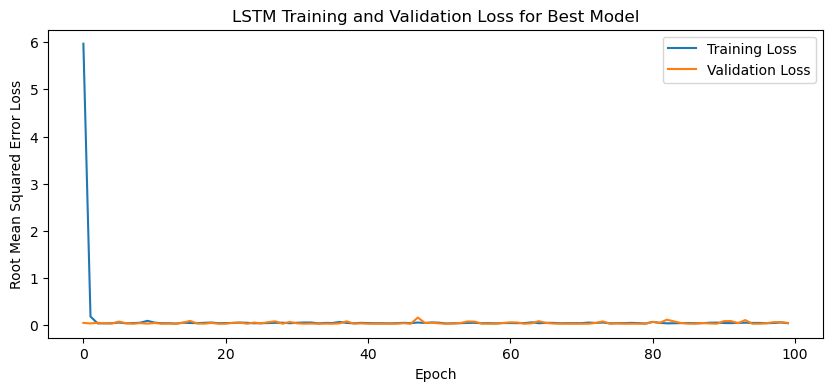

1/1 - 4s - loss: 0.0365 - 4s/epoch - 4s/step
Test Loss: 0.036477960646152496
1/1 [==============================] - 0s 62ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

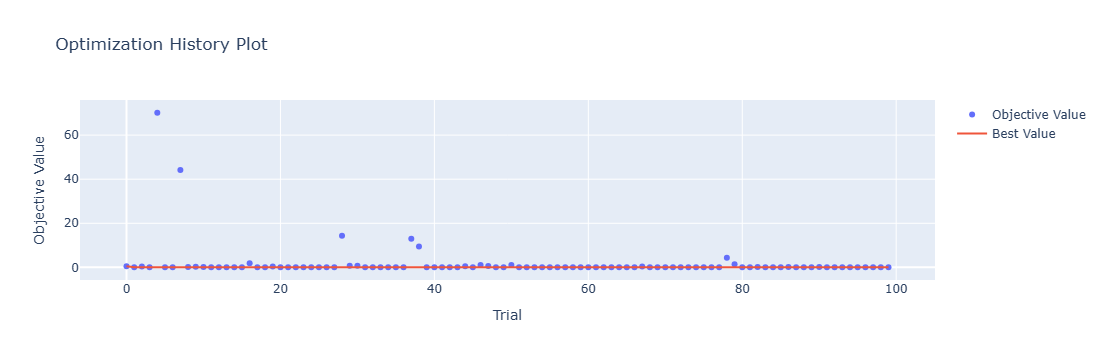

In [4]:
optuna.visualization.plot_optimization_history(study)

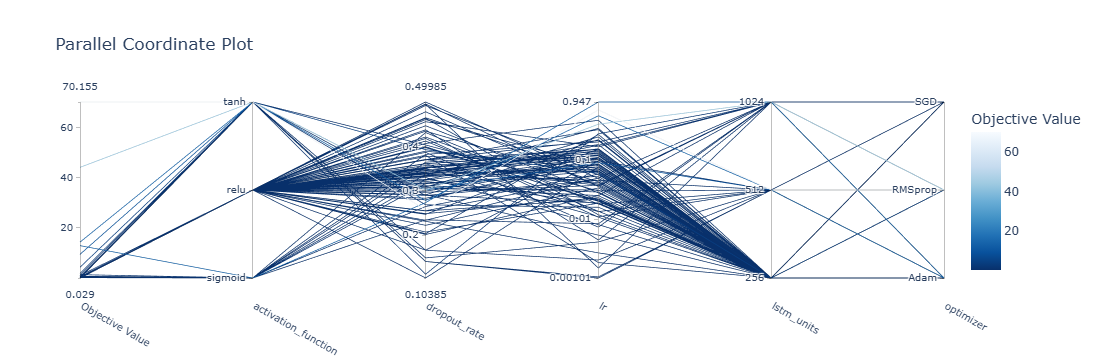

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

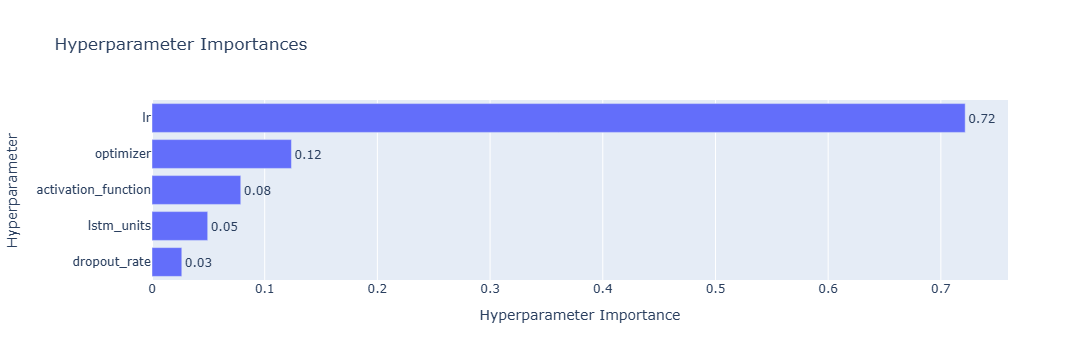

In [6]:
optuna.visualization.plot_param_importances(study)

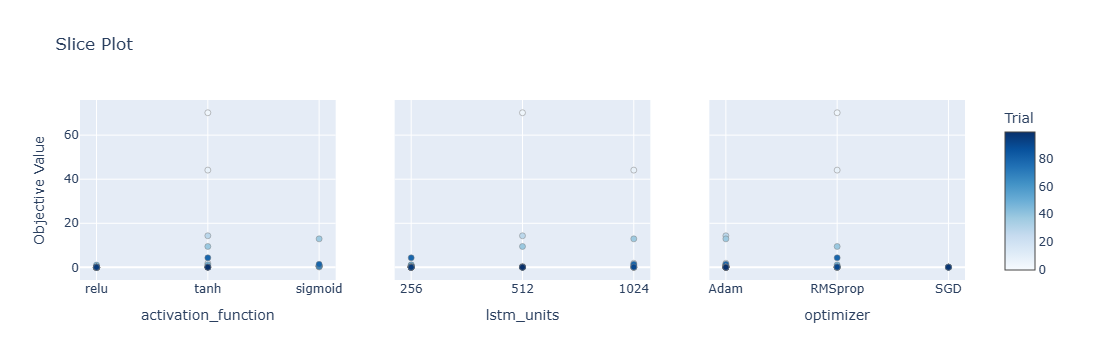

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

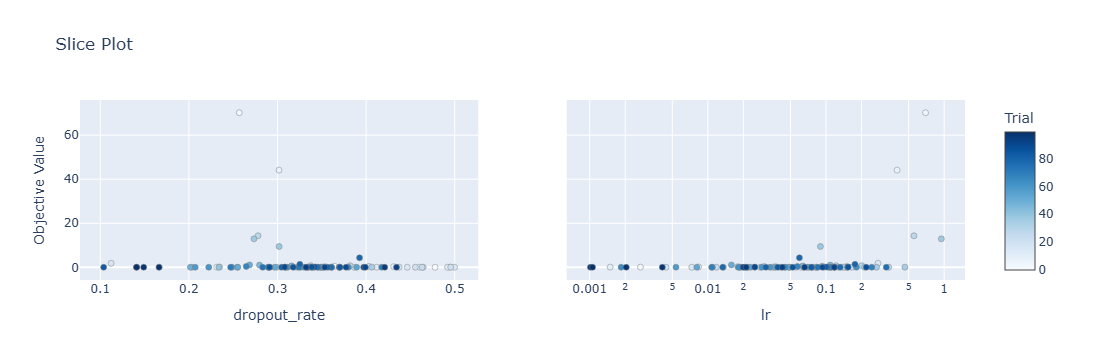

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 29s 119ms/step - loss: 6.3920 - accuracy: 0.0000e+00 - mae: 6.3920 - rmse: 6.3920 - mape: 1288.4927 - pearson: nan - val_loss: 0.0584 - val_accuracy: 0.0000e+00 - val_mae: 0.0584 - val_rmse: 0.0584 - val_mape: 13.4566 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 3s 35ms/step - loss: 0.0679 - accuracy: 0.0000e+00 - mae: 0.0679 - rmse: 0.0679 - mape: 14.3542 - pearson: nan - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mae: 0.0344 - val_rmse: 0.0344 - val_mape: 7.6360 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 3s 38ms/step - loss: 0.0449 - accuracy: 0.0000e+00 - mae: 0.0449 - rmse: 0.0449 - mape: 9.5579 - pearson: nan - val_loss: 0.1164 - val_accuracy: 0.0000e+00 - val_mae: 0.1164 - val_rmse: 0.1164 - val_mape: 26.1431 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 3s 37ms/step - loss: 0.0536 - accuracy: 0.0000e+00 - mae: 0.0536 - rmse: 0.0536 - mape:

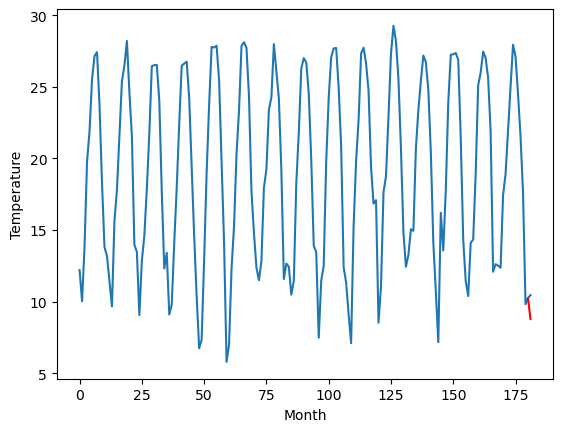

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.49		7.36		-0.13
[180, 181]
[6.41, 7.363469036817551]


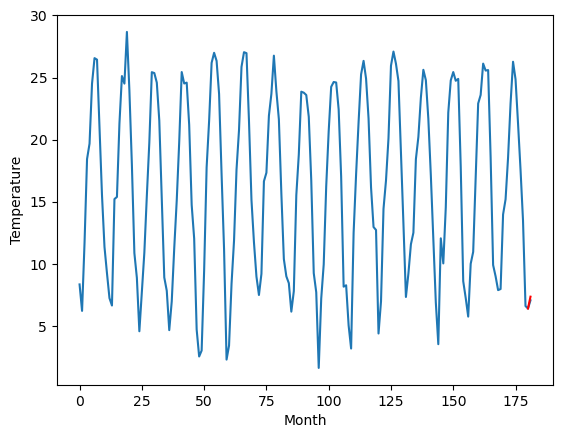

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.35		8.60		-0.75
[180, 181]
[7.6, 8.60346903681755]


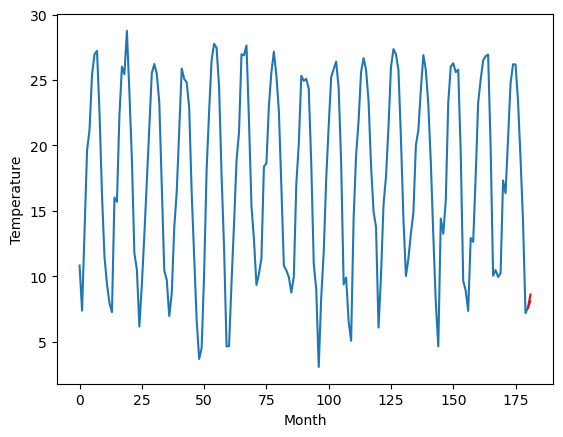

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.86		7.63		-0.23
[180, 181]
[11.89, 7.633469036817551]


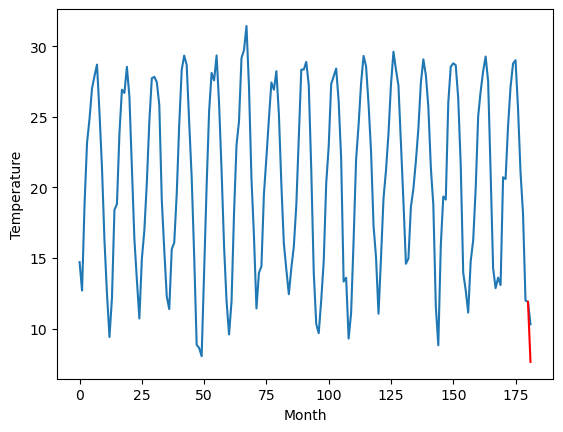

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.19		11.87		-0.32
[180, 181]
[10.96, 11.87346903681755]


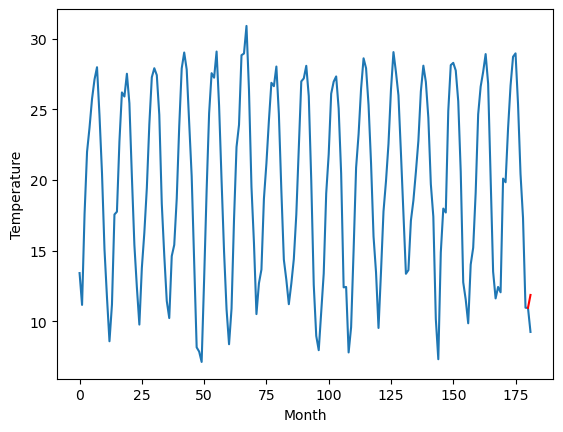

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.84		8.02		1.18
[180, 181]
[7.75, 8.02346903681755]


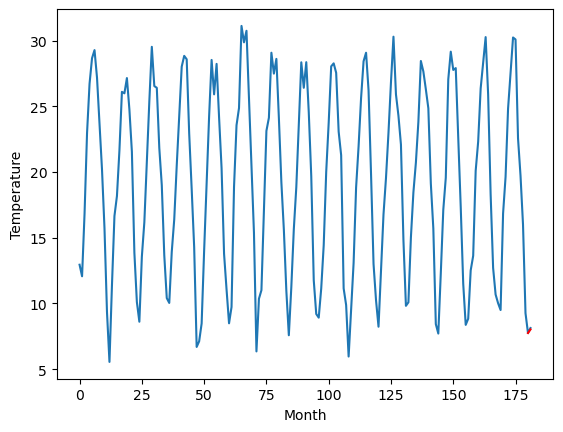

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.62		10.49		-0.13
[180, 181]
[6.17, 10.493469036817551]


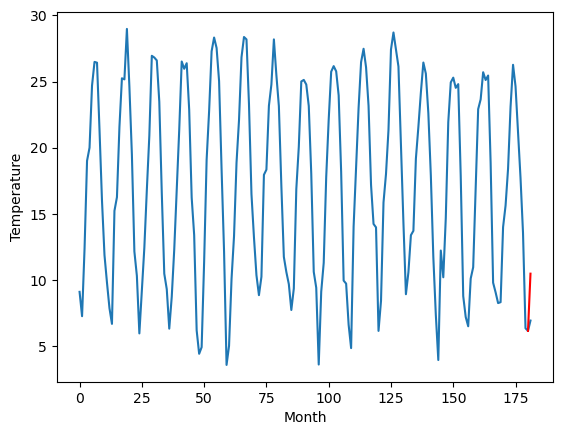

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.40		14.38		-0.02
[180, 181]
[4.57, 14.383469036817552]


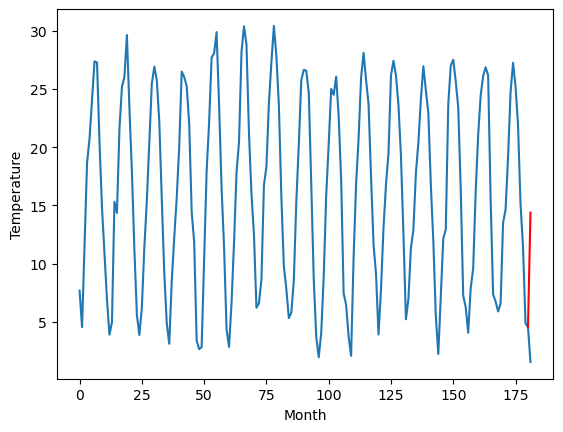

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.07		13.09		0.02
[180, 181]
[5.46, 13.09346903681755]


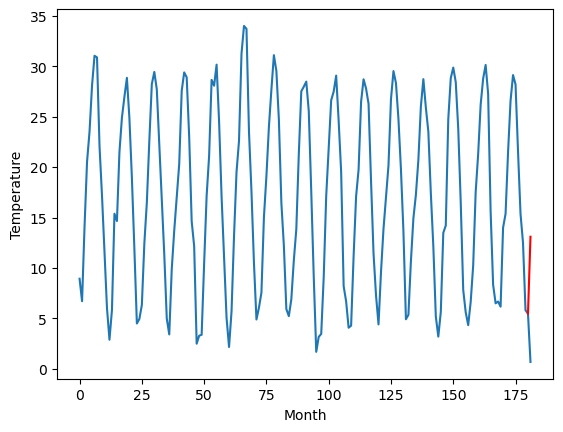

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.06		12.62		-0.44
[180, 181]
[5.42, 12.62346903681755]


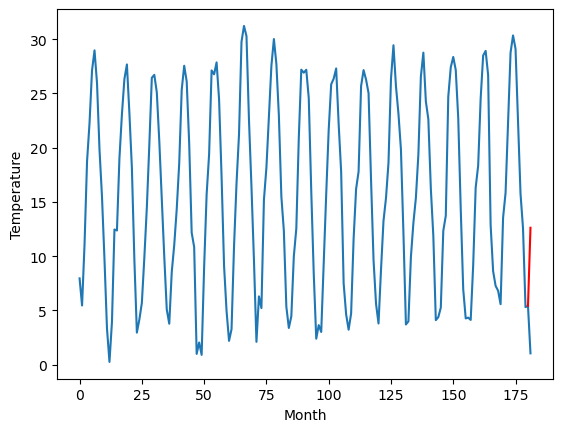

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.28		8.79		1.51
[180, 181]
[2.17, 8.79346903681755]


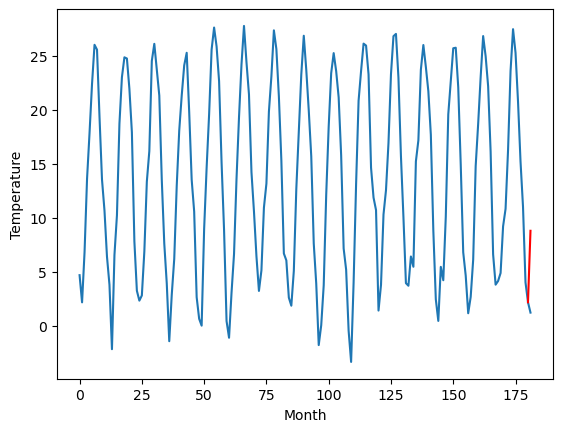

RangeIndex(start=1, stop=12, step=1)
[9.54, 7.489999999999999, 9.35, 7.859999999999999, 12.189999999999998, 6.84, 10.62, 14.4, 13.07, 13.06, 7.279999999999999]
[8.79346903681755, 7.363469036817551, 8.60346903681755, 7.633469036817551, 11.87346903681755, 8.02346903681755, 10.493469036817551, 14.383469036817552, 13.09346903681755, 12.62346903681755, 8.79346903681755]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    9.54   8.793469
1                 1    7.49   7.363469
2                 2    9.35   8.603469
3                 3    7.86   7.633469
4                 4   12.19  11.873469
5                 5    6.84   8.023469
6                 6   10.62  10.493469
7                 7   14.40  14.383469
8                 8   13.07  13.093469
9                 9   13.06  12.623469
10               10    7.28   8.793469


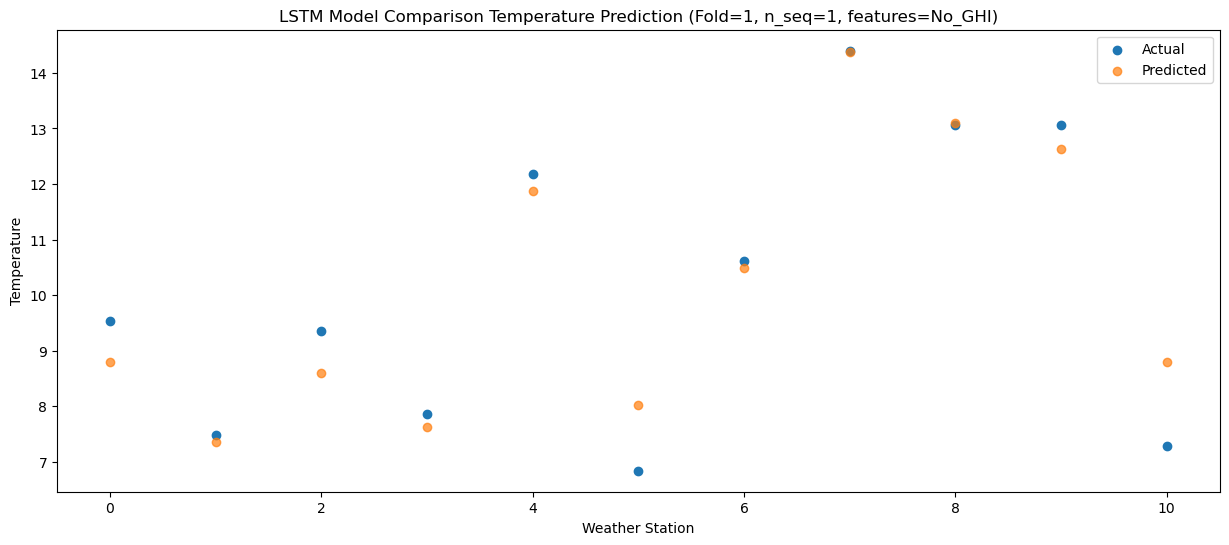

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_4 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_5 (LSTM)               (1, 256)                  525312    
                                                                 
 dropout_5 (Dropout)         (1, 256)                  0         
                                                                 
 dense_6 (Dense)             (1, 256)                  65792     
                                                                 
 dense_7 (Dense)             (1, 128)                  32896     
                                                                 
 dense_8 (Dense)             (1, 1)                   

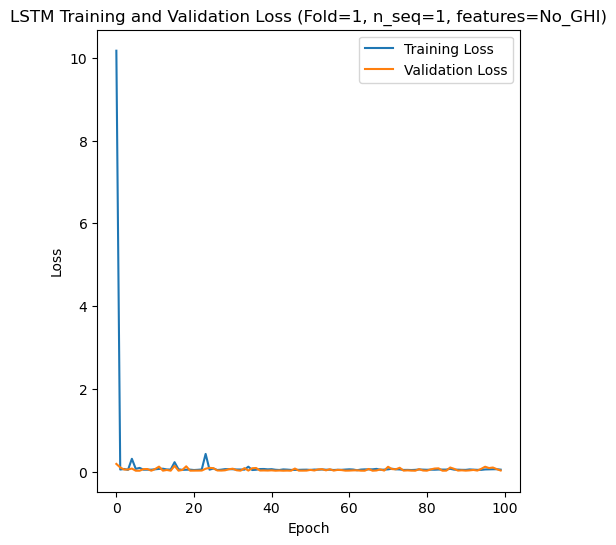

Epoch 1/100
84/84 [==============================] - 21s 75ms/step - loss: 7.6048 - accuracy: 0.0000e+00 - mae: 7.6048 - rmse: 7.6048 - mape: 1655.9126 - pearson: nan - val_loss: 0.1441 - val_accuracy: 0.0000e+00 - val_mae: 0.1441 - val_rmse: 0.1441 - val_mape: 32.4288 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 2s 24ms/step - loss: 0.0521 - accuracy: 0.0000e+00 - mae: 0.0521 - rmse: 0.0521 - mape: 11.0985 - pearson: nan - val_loss: 0.0514 - val_accuracy: 0.0000e+00 - val_mae: 0.0514 - val_rmse: 0.0514 - val_mape: 11.6573 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 2s 22ms/step - loss: 0.0577 - accuracy: 0.0000e+00 - mae: 0.0577 - rmse: 0.0577 - mape: 12.1547 - pearson: nan - val_loss: 0.1873 - val_accuracy: 0.0000e+00 - val_mae: 0.1873 - val_rmse: 0.1873 - val_mape: 42.1080 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0541 - accuracy: 0.0000e+00 - mae: 0.0541 - rmse: 0.0541 - mape

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 26ms/step
Month at t+1:
t+1 RMSE: 1.029576
t+1 MAE: 0.781374
t+1 MAPE: 0.115423
t+1 R2_SCORE: 0.939449
Weather Station 1:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.88		11.52		-0.36
[180, 181]
[5.9, 11.520697250366212]


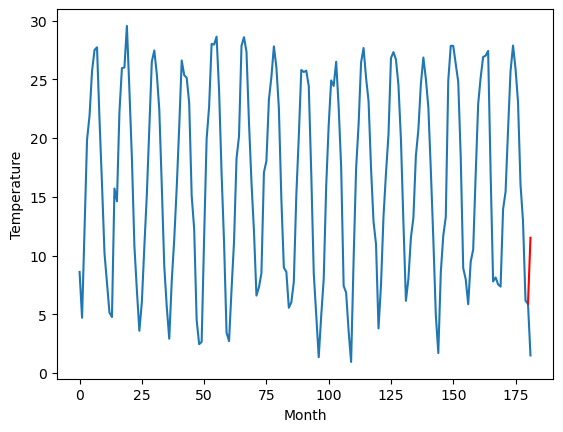

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.69		6.15		-0.54
[180, 181]
[2.63, 6.1506972503662105]


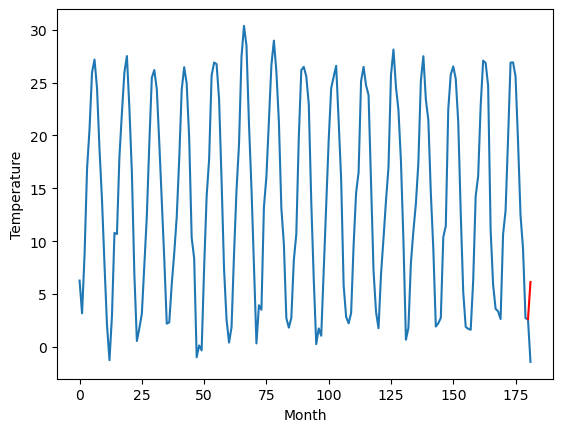

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.70		11.42		-1.28
[180, 181]
[16.55, 11.42069725036621]


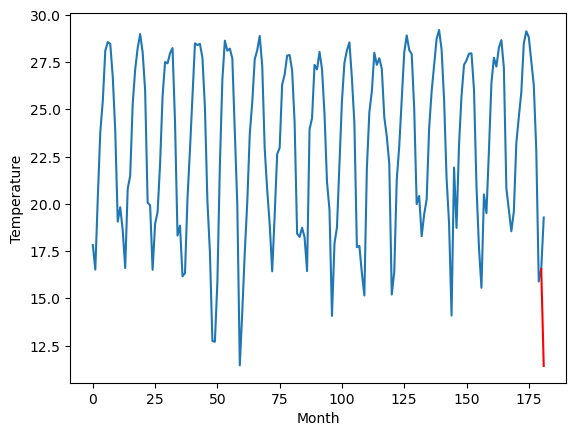

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.49		7.95		2.46
[180, 181]
[-0.83, 7.950697250366211]


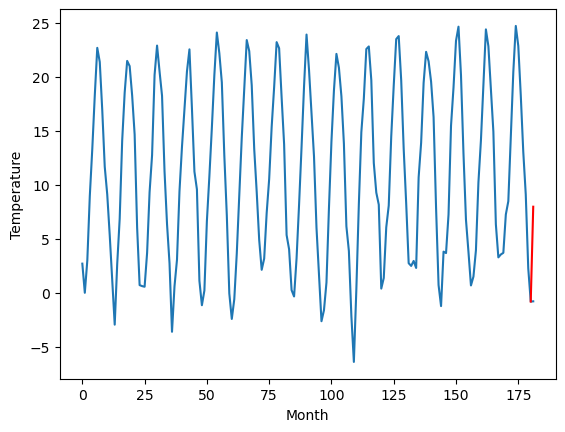

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.96		7.99		-0.97
[180, 181]
[11.52, 7.99069725036621]


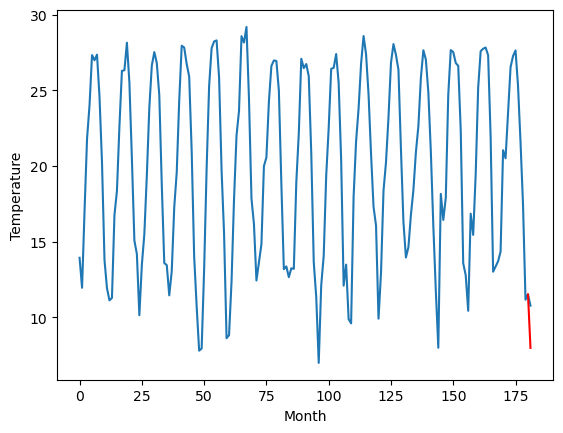

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.69		5.66		-0.03
[180, 181]
[11.47, 5.660697250366211]


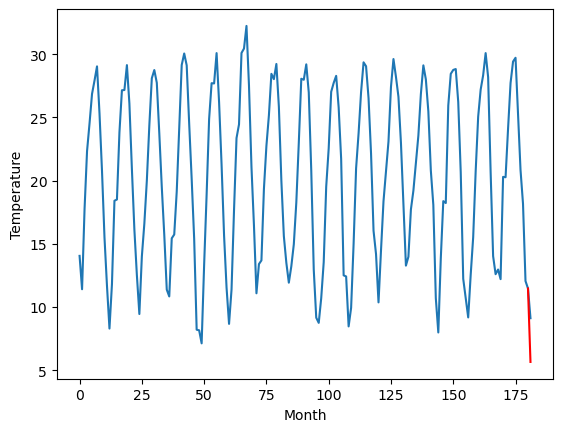

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.12		17.20		0.08
[180, 181]
[7.75, 17.20069725036621]


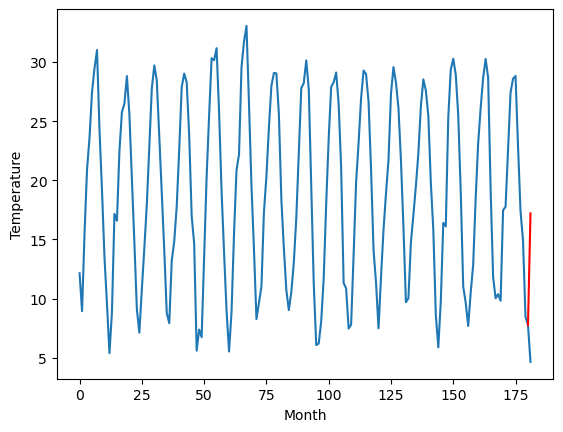

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.22		2.06		-1.16
[180, 181]
[4.9, 2.060697250366211]


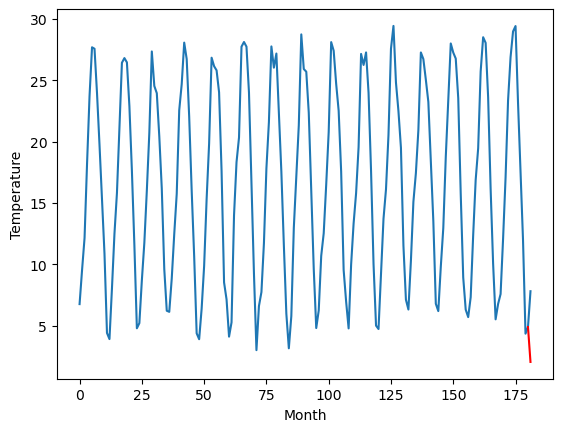

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.88		13.32		-0.56
[180, 181]
[14.14, 13.32069725036621]


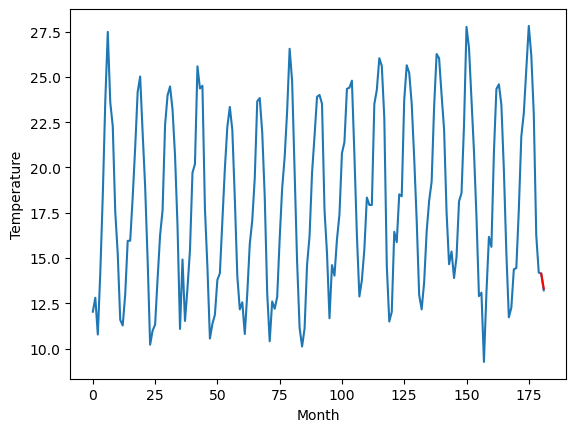

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.64		13.43		-0.21
[180, 181]
[5.55, 13.430697250366212]


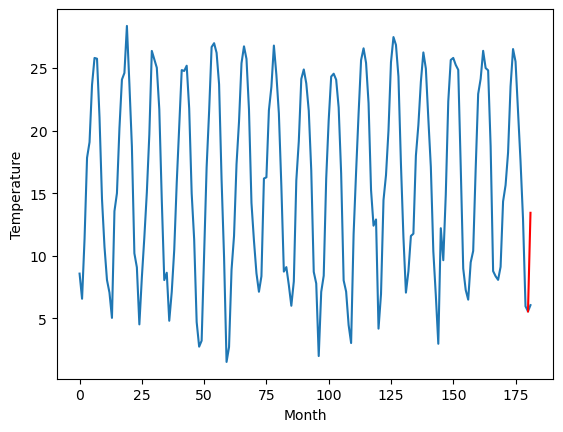

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.47		11.52		-0.95
[180, 181]
[3.19, 11.520697250366212]


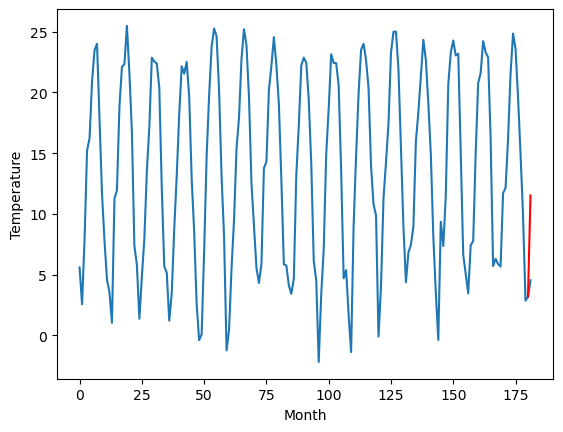

RangeIndex(start=1, stop=12, step=1)
[11.88, 6.69, 12.7, 5.490000000000001, 8.96, 5.69, 17.12, 3.2200000000000015, 13.880000000000003, 13.64, 12.47]
[11.520697250366212, 6.1506972503662105, 11.42069725036621, 7.950697250366211, 7.99069725036621, 5.660697250366211, 17.20069725036621, 2.060697250366211, 13.32069725036621, 13.430697250366212, 11.520697250366212]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   11.88  11.520697
1                 1    6.69   6.150697
2                 2   12.70  11.420697
3                 3    5.49   7.950697
4                 4    8.96   7.990697
5                 5    5.69   5.660697
6                 6   17.12  17.200697
7                 7    3.22   2.060697
8                 8   13.88  13.320697
9                 9   13.64  13.430697
10               10   12.47  11.520697


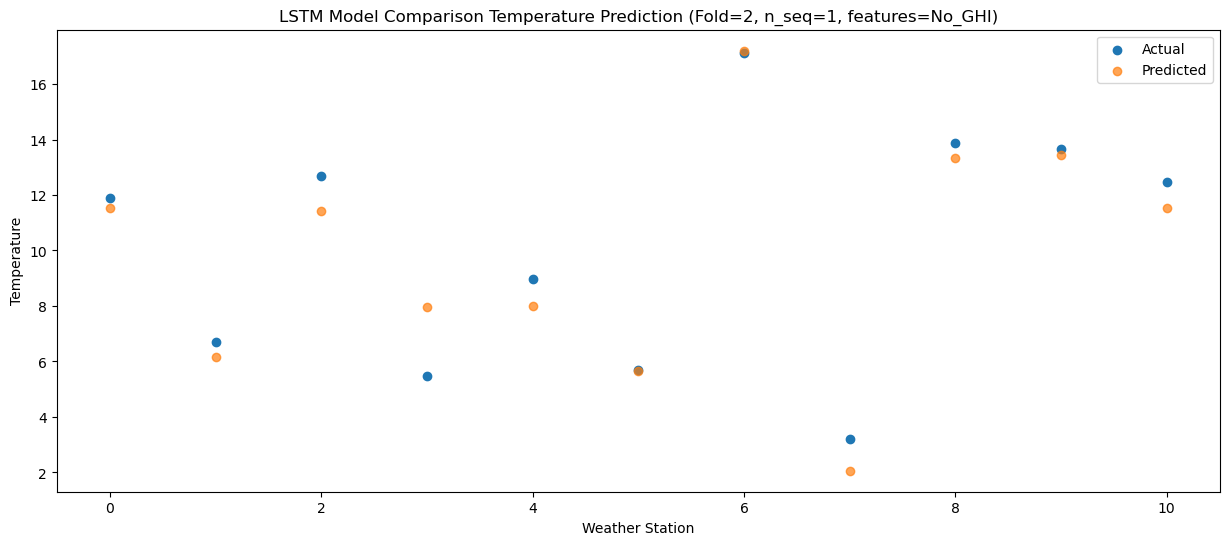

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_6 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_7 (LSTM)               (1, 256)                  525312    
                                                                 
 dropout_7 (Dropout)         (1, 256)                  0         
                                                                 
 dense_9 (Dense)             (1, 256)                  65792     
                                                                 
 dense_10 (Dense)            (1, 128)                  32896     
                                                                 
 dense_11 (Dense)            (1, 1)                   

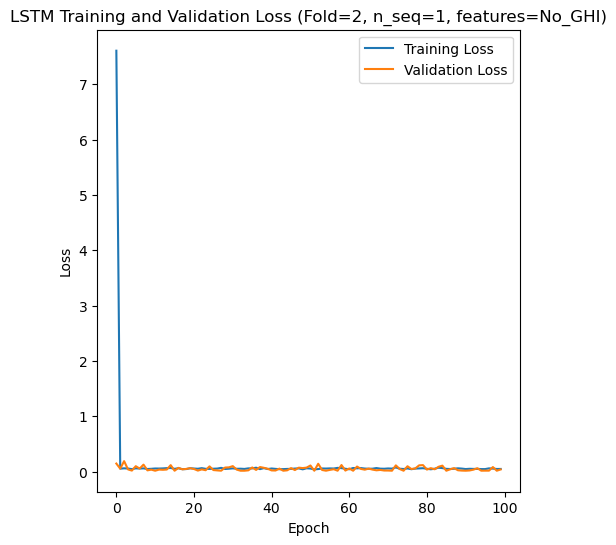

Epoch 1/100
84/84 [==============================] - 17s 73ms/step - loss: 7.0482 - accuracy: 0.0000e+00 - mae: 7.0482 - rmse: 7.0482 - mape: 1556.0479 - pearson: nan - val_loss: 0.0893 - val_accuracy: 0.0000e+00 - val_mae: 0.0893 - val_rmse: 0.0893 - val_mape: 18.6196 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0539 - accuracy: 0.0000e+00 - mae: 0.0539 - rmse: 0.0539 - mape: 11.7853 - pearson: nan - val_loss: 0.0364 - val_accuracy: 0.0000e+00 - val_mae: 0.0364 - val_rmse: 0.0364 - val_mape: 7.3001 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0484 - accuracy: 0.0000e+00 - mae: 0.0484 - rmse: 0.0484 - mape: 10.7850 - pearson: nan - val_loss: 0.0461 - val_accuracy: 0.0000e+00 - val_mae: 0.0461 - val_rmse: 0.0461 - val_mape: 9.1489 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 2s 20ms/step - loss: 0.0485 - accuracy: 0.0000e+00 - mae: 0.0485 - rmse: 0.0485 - mape: 

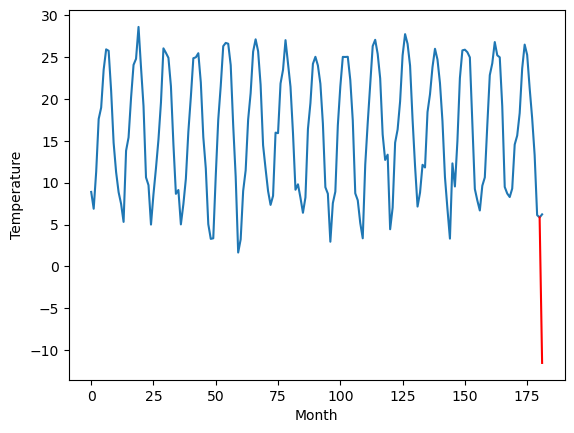

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.42		6.28		-2.14
[180, 181]
[3.2, 6.282378740310669]


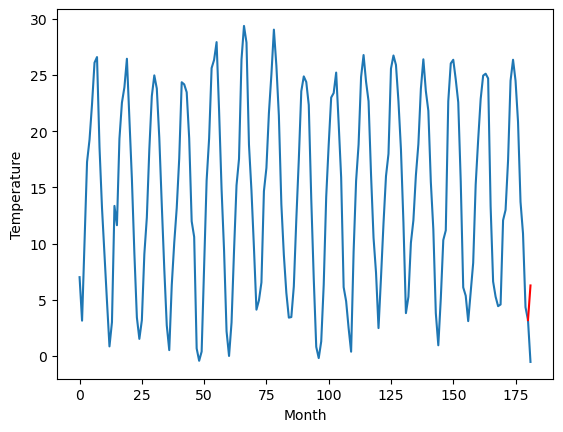

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.30		5.75		-4.55
[180, 181]
[8.48, 5.752378740310668]


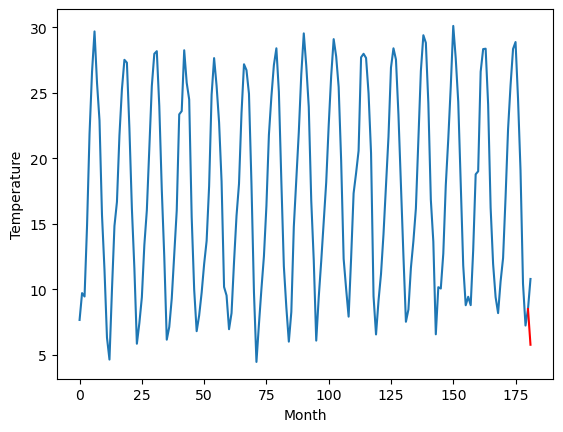

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.74		-0.09		-1.83
[180, 181]
[1.55, -0.08762125968933088]


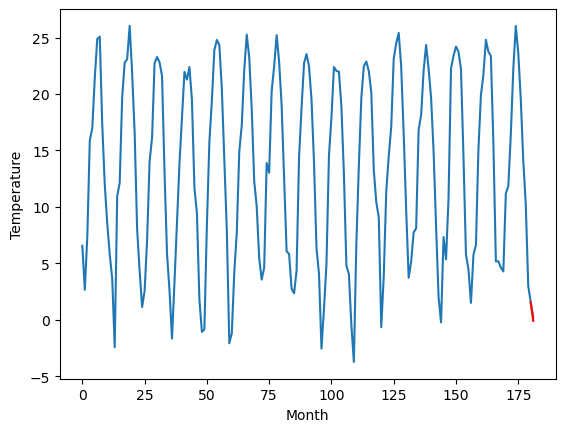

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.43		5.61		-1.82
[180, 181]
[1.08, 5.612378740310669]


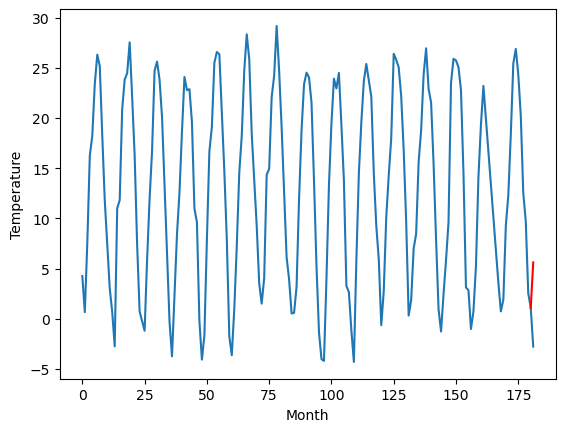

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.57		3.73		-1.84
[180, 181]
[0.21, 3.7323787403106685]


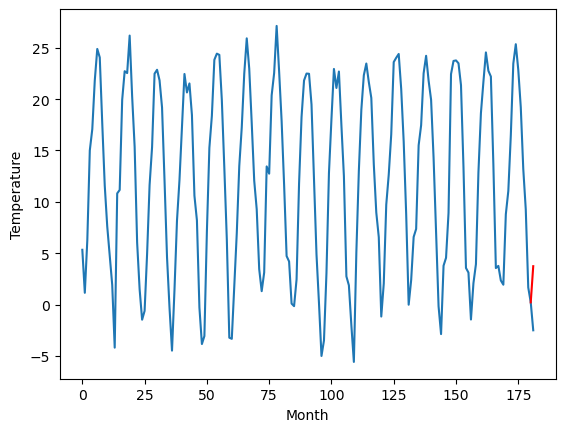

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.92		4.36		-3.56
[180, 181]
[-8.22, 4.362378740310669]


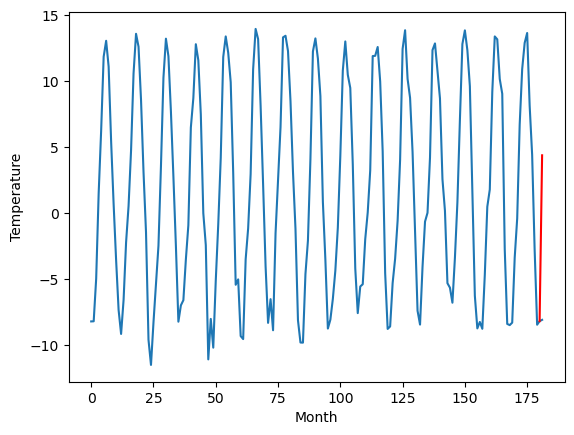

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.12		3.28		-3.84
[180, 181]
[10.04, 3.2823787403106692]


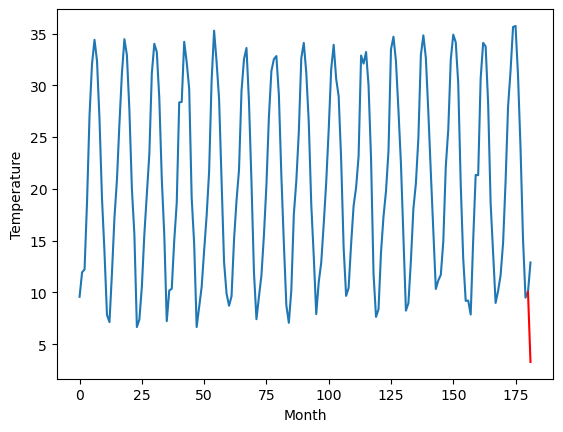

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.47		0.96		-4.51
[180, 181]
[9.17, 0.962378740310669]


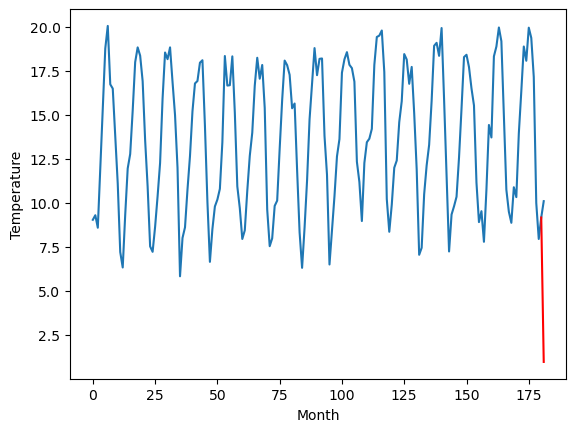

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.31		2.04		-0.27
[180, 181]
[0.94, 2.042378740310669]


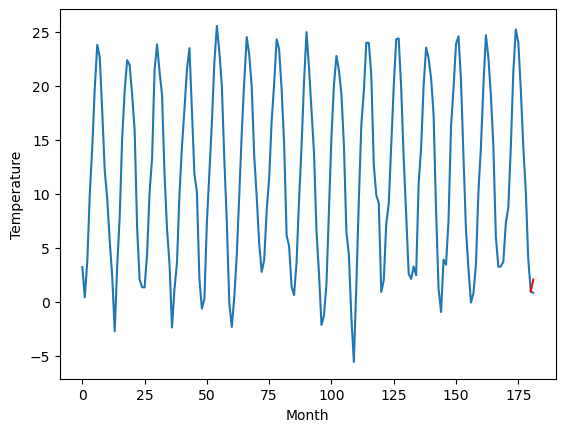

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-9.80		-11.53		-1.73
[180, 181]
[-0.13, -11.527621259689331]


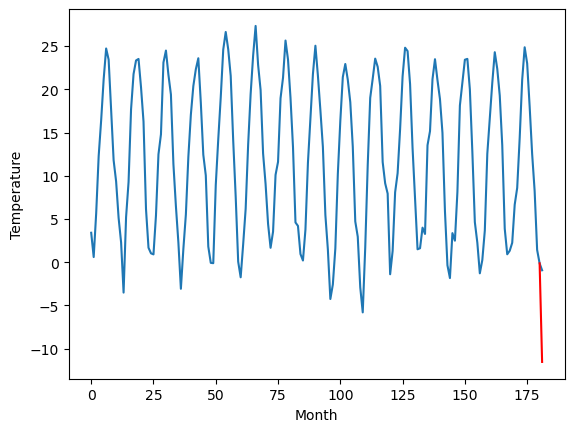

RangeIndex(start=1, stop=12, step=1)
[-8.520000000000001, 8.420000000000002, 10.299999999999999, 1.7399999999999998, 7.430000000000001, 5.5699999999999985, 7.92, 7.119999999999999, 5.4700000000000015, 2.3099999999999996, -9.8]
[-11.527621259689331, 6.282378740310669, 5.752378740310668, -0.08762125968933088, 5.612378740310669, 3.7323787403106685, 4.362378740310669, 3.2823787403106692, 0.962378740310669, 2.042378740310669, -11.527621259689331]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   -8.52 -11.527621
1                 1    8.42   6.282379
2                 2   10.30   5.752379
3                 3    1.74  -0.087621
4                 4    7.43   5.612379
5                 5    5.57   3.732379
6                 6    7.92   4.362379
7                 7    7.12   3.282379
8                 8    5.47   0.962379
9                 9    2.31   2.042379
10               10   -9.80 -11.527621


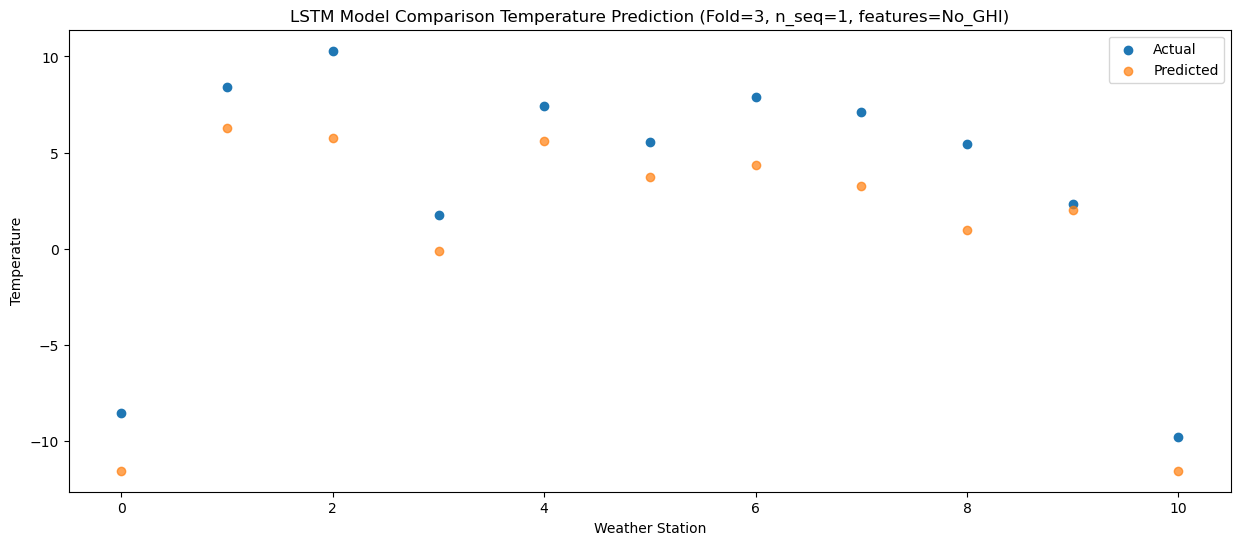

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 256)               2279424   
                                                                 
 dropout_8 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_9 (LSTM)               (1, 256)                  525312    
                                                                 
 dropout_9 (Dropout)         (1, 256)                  0         
                                                                 
 dense_12 (Dense)            (1, 256)                  65792     
                                                                 
 dense_13 (Dense)            (1, 128)                  32896     
                                                                 
 dense_14 (Dense)            (1, 1)                   

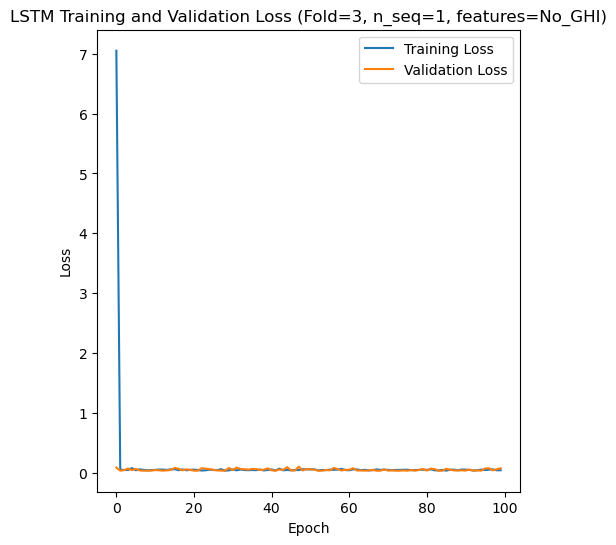

Epoch 1/100
84/84 [==============================] - 6s 26ms/step - loss: 8.9963 - accuracy: 0.0000e+00 - mae: 8.9963 - rmse: 8.9963 - mape: 2016.1765 - pearson: nan - val_loss: 0.0512 - val_accuracy: 0.0000e+00 - val_mae: 0.0512 - val_rmse: 0.0512 - val_mape: 10.6969 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0647 - accuracy: 0.0000e+00 - mae: 0.0647 - rmse: 0.0647 - mape: 13.5705 - pearson: nan - val_loss: 0.0590 - val_accuracy: 0.0000e+00 - val_mae: 0.0590 - val_rmse: 0.0590 - val_mape: 13.5510 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0584 - accuracy: 0.0000e+00 - mae: 0.0584 - rmse: 0.0584 - mape: 12.3848 - pearson: nan - val_loss: 0.0813 - val_accuracy: 0.0000e+00 - val_mae: 0.0813 - val_rmse: 0.0813 - val_mape: 19.1757 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0567 - accuracy: 0.0000e+00 - mae: 0.0567 - rmse: 0.0567 - mape:

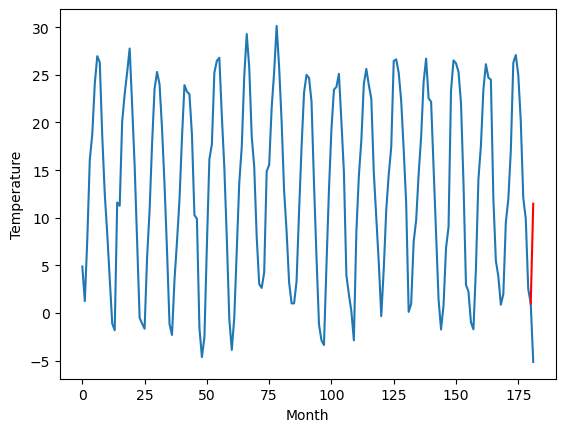

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		9.80		1.46
[180, 181]
[14.25, 9.797846212387086]


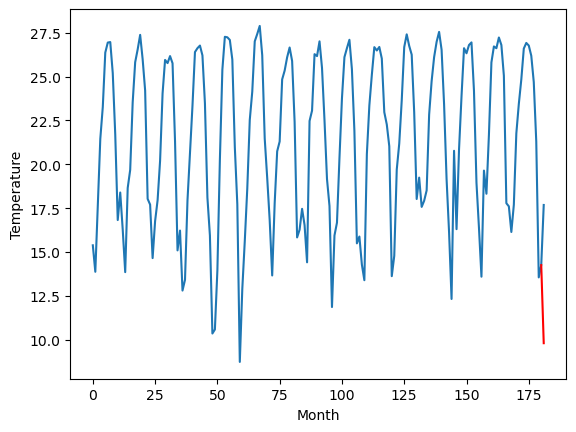

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		6.42		2.13
[180, 181]
[9.06, 6.417846212387085]


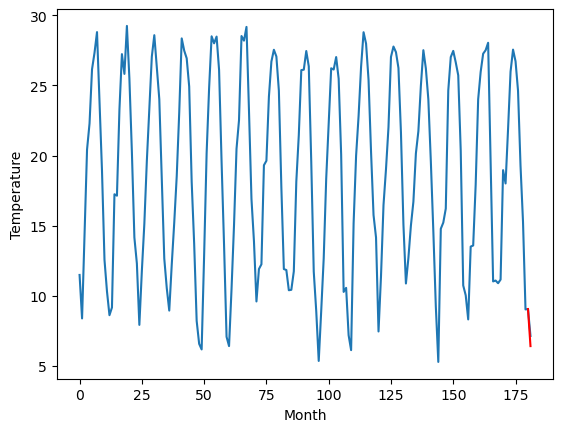

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		5.78		3.08
[180, 181]
[7.48, 5.777846212387085]


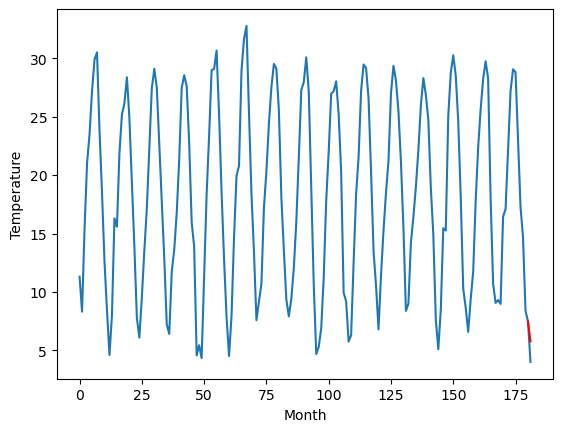

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		7.05		2.76
[180, 181]
[7.33, 7.047846212387085]


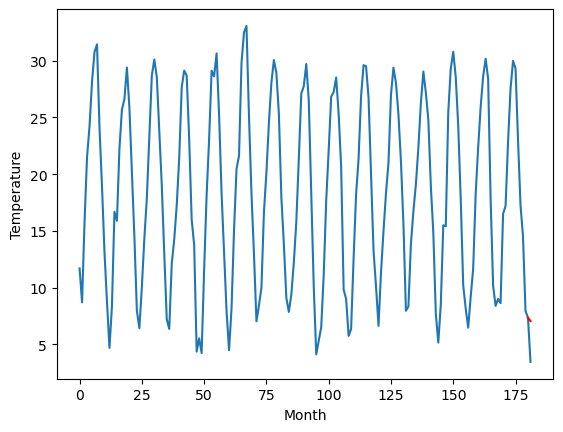

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		17.54		3.26
[180, 181]
[6.59, 17.537846212387088]


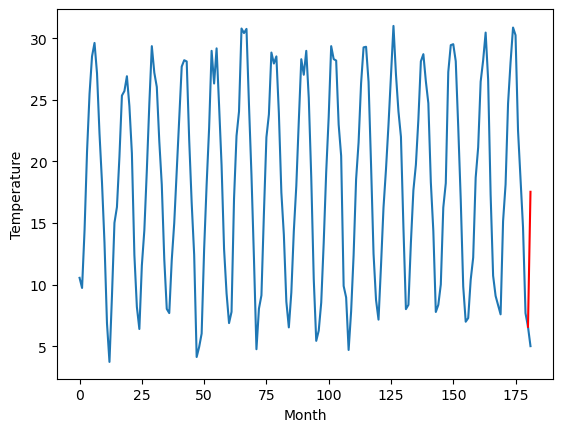

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		13.65		1.93
[180, 181]
[6.04, 13.647846212387085]


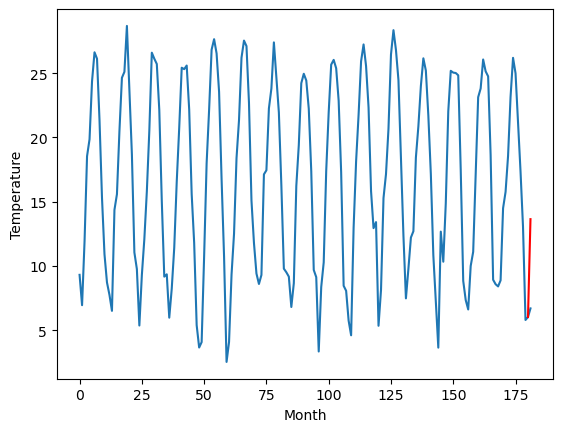

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		13.47		3.83
[180, 181]
[3.13, 13.467846212387085]


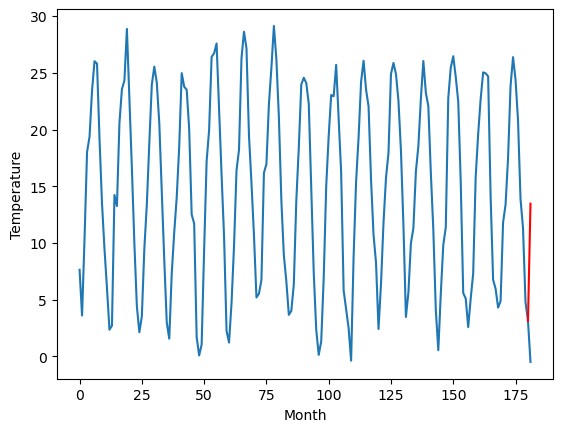

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		13.85		3.74
[180, 181]
[-0.29, 13.847846212387084]


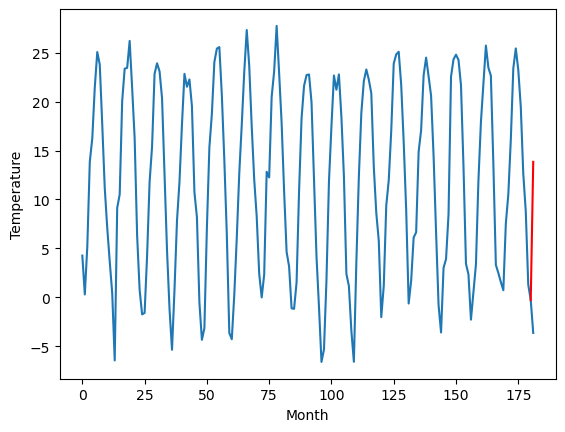

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		12.72		4.19
[180, 181]
[-1.03, 12.717846212387085]


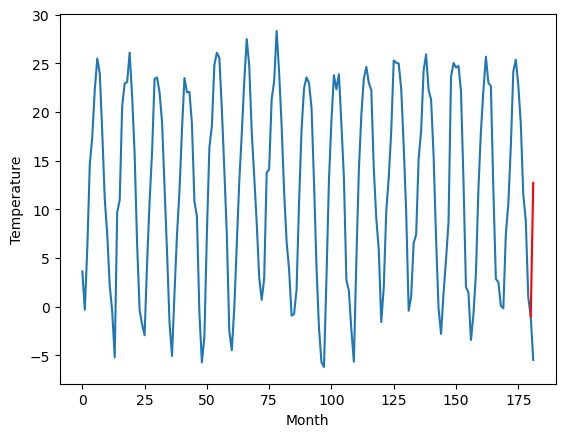

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		11.48		4.08
[180, 181]
[-2.29, 11.477846212387085]


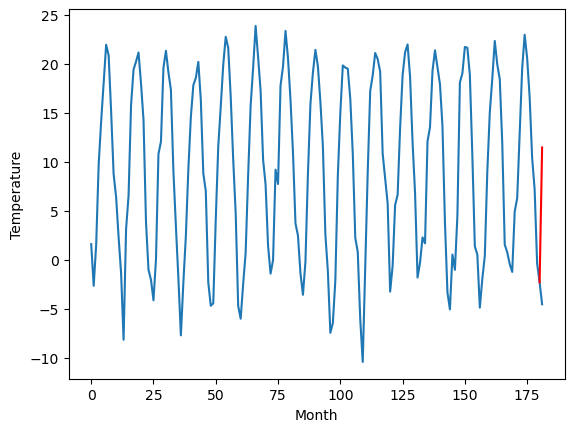

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[11.477846212387085, 9.797846212387086, 6.417846212387085, 5.777846212387085, 7.047846212387085, 17.537846212387088, 13.647846212387085, 13.467846212387085, 13.847846212387084, 12.717846212387085, 11.477846212387085]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81  11.477846
1                 1    8.34   9.797846
2                 2    4.29   6.417846
3                 3    2.70   5.777846
4                 4    4.29   7.047846
5                 5   14.28  17.537846
6                 6   11.72  13.647846
7                 7    9.64  13.467846
8                 8   10.11  13.847846
9                 9    8.53  12.717846
10               10    7.40  11.477846


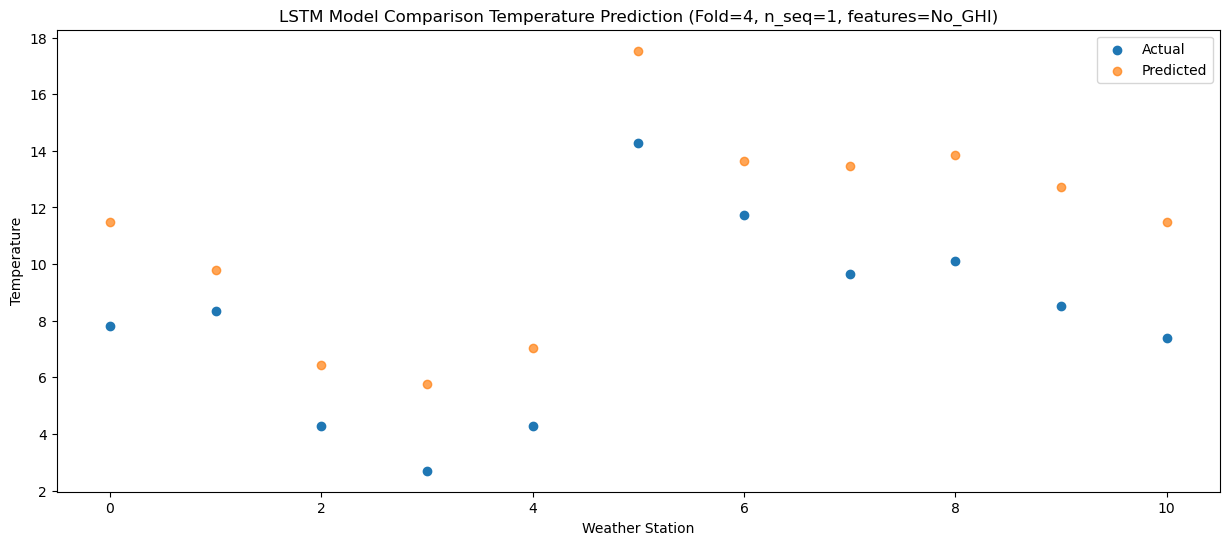

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 256)               2279424   
                                                                 
 dropout_10 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_11 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_11 (Dropout)        (1, 256)                  0         
                                                                 
 dense_15 (Dense)            (1, 256)                  65792     
                                                                 
 dense_16 (Dense)            (1, 128)                  32896     
                                                                 
 dense_17 (Dense)            (1, 1)                   

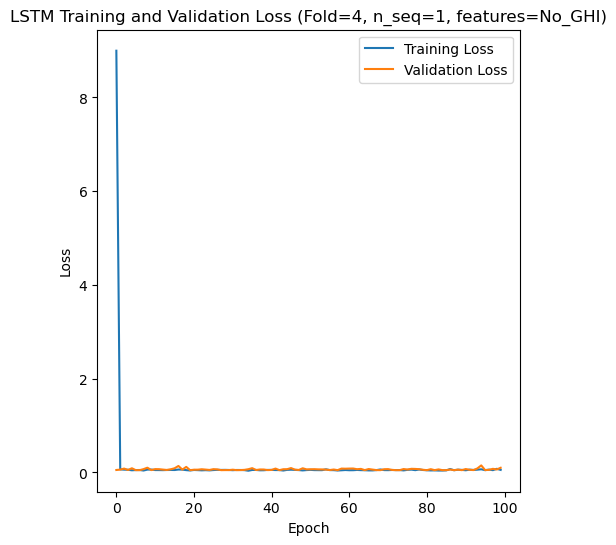

[[1.4876921706680213], [0.6862755934596769], [1.029576113357544], [2.9399415510018563], [3.2235769726466383]]
[[1.2300016372854061], [0.4966049832647493], [0.7813744770396844], [2.643075805143876], [3.1005734851143583]]
[[0.15228600529577777], [0.059906823126767074], [0.1154225765023593], [0.4343356269200441], [0.4658800355391961]]
[[0.6460909291180381], [0.9280096873950358], [0.9394492887446865], [0.7899134548883908], [0.020659813177249853]]
[[[6.9418165445327755], [5.961816544532776], [4.581816544532776], [3.381816544532776], [10.301816544532777], [12.611816544532775], [7.001816544532776], [12.321816544532776], [11.391816544532777], [8.881816544532775], [6.9418165445327755]], [[8.79346903681755], [7.363469036817551], [8.60346903681755], [7.633469036817551], [11.87346903681755], [8.02346903681755], [10.493469036817551], [14.383469036817552], [13.09346903681755], [12.62346903681755], [8.79346903681755]], [[11.520697250366212], [6.1506972503662105], [11.42069725036621], [7.9506972503662

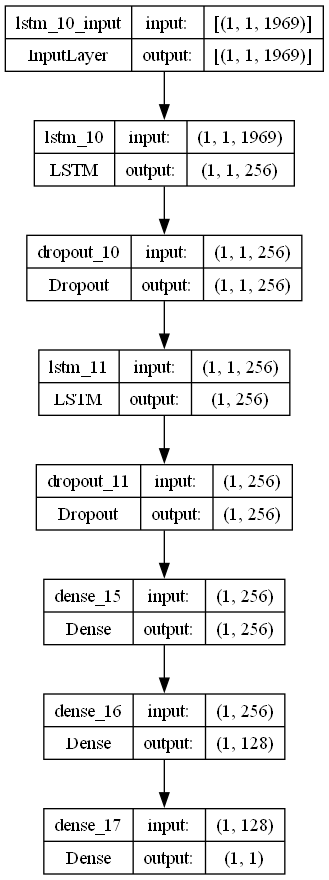

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.11014893392526853
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.30928234919484604

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)